---
title: "FM5323 Data Science and Machine Learning in Finance"
subtitle: "Project 2: Volatility Forecasting"
author: "Po-Chin Huang"
format: 
  html:
    number-sections: true
    toc: true
    code-fold: true
embed-resources: true
jupyter: python3
---

## **Part 0: Preparation**

### Import libraries

In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
from arch import arch_model
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [27]:
# ignore warning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

### Download Data

In [28]:
# donwload the data

df_spy = pdr.get_data_yahoo('SPY', start = '2004-12-31', end = '2016-04-02').reset_index()
df_spy.columns = df_spy.columns.str.lower().str.replace(' ', '_')
df_spy.rename(columns = {'date':'trade_date'}, inplace = True)
df_spy.insert(0, 'ticker', 'SPY')
df_spy

[*********************100%***********************]  1 of 1 completed


ticker trade_date        open        high         low       close  \
0       SPY 2004-12-31  121.300003  121.660004  120.800003  120.870003   
1       SPY 2005-01-03  121.559998  121.760002  119.900002  120.300003   
2       SPY 2005-01-04  120.459999  120.540001  118.440002  118.830002   
3       SPY 2005-01-05  118.739998  119.250000  118.000000  118.010002   
4       SPY 2005-01-06  118.440002  119.150002  118.260002  118.610001   
...     ...        ...         ...         ...         ...         ...   
2827    SPY 2016-03-28  203.610001  203.860001  202.710007  203.240005   
2828    SPY 2016-03-29  202.759995  205.250000  202.399994  205.119995   
2829    SPY 2016-03-30  206.300003  206.869995  205.589996  206.020004   
2830    SPY 2016-03-31  205.910004  206.410004  205.330002  205.520004   
2831    SPY 2016-04-01  204.350006  207.139999  203.979996  206.919998   

       adj_close     volume  
0      83.234695   28648800  
1      82.842194   55748000  
2      81.829880   69167600  
3      81.265205   65667300  
4      81.678398   47814700  
...          ...        ...  
2827  175.764969   62408200  
2828  177.390778   92922900  
2829  178.169144   86365300  
2830  177.736694   94584100  
2831  178.947464  114423500  

[2832 rows x 8 columns]

### Calculate Returns

In [29]:
# ocmpute daily returns

df_spy['dly_ret'] = np.log(df_spy['close']).diff()
df_spy = df_spy[1:].reset_index(drop = True)
df_spy

ticker trade_date        open        high         low       close  \
0       SPY 2005-01-03  121.559998  121.760002  119.900002  120.300003   
1       SPY 2005-01-04  120.459999  120.540001  118.440002  118.830002   
2       SPY 2005-01-05  118.739998  119.250000  118.000000  118.010002   
3       SPY 2005-01-06  118.440002  119.150002  118.260002  118.610001   
4       SPY 2005-01-07  118.970001  119.230003  118.129997  118.440002   
...     ...        ...         ...         ...         ...         ...   
2826    SPY 2016-03-28  203.610001  203.860001  202.710007  203.240005   
2827    SPY 2016-03-29  202.759995  205.250000  202.399994  205.119995   
2828    SPY 2016-03-30  206.300003  206.869995  205.589996  206.020004   
2829    SPY 2016-03-31  205.910004  206.410004  205.330002  205.520004   
2830    SPY 2016-04-01  204.350006  207.139999  203.979996  206.919998   

       adj_close     volume   dly_ret  
0      82.842194   55748000 -0.004727  
1      81.829880   69167600 -0.012295  
2      81.265205   65667300 -0.006925  
3      81.678398   47814700  0.005071  
4      81.561317   55847700 -0.001434  
...          ...        ...       ...  
2826  175.764969   62408200  0.000591  
2827  177.390778   92922900  0.009208  
2828  178.169144   86365300  0.004378  
2829  177.736694   94584100 -0.002430  
2830  178.947464  114423500  0.006789  

[2831 rows x 9 columns]

### Convert to Weekly

In [30]:
weekday = df_spy['trade_date'].dt.weekday
weekday

0       0
1       1
2       2
3       3
4       4
       ..
2826    0
2827    1
2828    2
2829    3
2830    4
Name: trade_date, Length: 2831, dtype: int32

In [31]:
week_num = []
ix_week = 0
week_num.append(ix_week)
for ix in range(0, len(weekday) - 1):
    prev_day = weekday[ix]
    curr_day = weekday[ix + 1]
    if curr_day < prev_day:
        ix_week = ix_week + 1
    week_num.append(ix_week)
np.array(week_num)

array([  0,   0,   0, ..., 586, 586, 586])

In [32]:
df_spy.insert(2, 'week_num', week_num)
df_spy

ticker trade_date  week_num        open        high         low  \
0       SPY 2005-01-03         0  121.559998  121.760002  119.900002   
1       SPY 2005-01-04         0  120.459999  120.540001  118.440002   
2       SPY 2005-01-05         0  118.739998  119.250000  118.000000   
3       SPY 2005-01-06         0  118.440002  119.150002  118.260002   
4       SPY 2005-01-07         0  118.970001  119.230003  118.129997   
...     ...        ...       ...         ...         ...         ...   
2826    SPY 2016-03-28       586  203.610001  203.860001  202.710007   
2827    SPY 2016-03-29       586  202.759995  205.250000  202.399994   
2828    SPY 2016-03-30       586  206.300003  206.869995  205.589996   
2829    SPY 2016-03-31       586  205.910004  206.410004  205.330002   
2830    SPY 2016-04-01       586  204.350006  207.139999  203.979996   

           close   adj_close     volume   dly_ret  
0     120.300003   82.842194   55748000 -0.004727  
1     118.830002   81.829880   69167600 -0.012295  
2     118.010002   81.265205   65667300 -0.006925  
3     118.610001   81.678398   47814700  0.005071  
4     118.440002   81.561317   55847700 -0.001434  
...          ...         ...        ...       ...  
2826  203.240005  175.764969   62408200  0.000591  
2827  205.119995  177.390778   92922900  0.009208  
2828  206.020004  178.169144   86365300  0.004378  
2829  205.520004  177.736694   94584100 -0.002430  
2830  206.919998  178.947464  114423500  0.006789  

[2831 rows x 10 columns]

In [33]:
df_start_end = \
    (
    df_spy.groupby(['week_num'], as_index = False)[['trade_date']].agg([min, max])['trade_date']
    .rename(columns = {'min':'week_start', 'max':'week_end'})
    .reset_index()
    .rename(columns = {'index':'week_num'})
    )
df_start_end

week_num week_start   week_end
0           0 2005-01-03 2005-01-07
1           1 2005-01-10 2005-01-14
2           2 2005-01-18 2005-01-21
3           3 2005-01-24 2005-01-28
4           4 2005-01-31 2005-02-04
..        ...        ...        ...
582       582 2016-02-29 2016-03-04
583       583 2016-03-07 2016-03-11
584       584 2016-03-14 2016-03-18
585       585 2016-03-21 2016-03-24
586       586 2016-03-28 2016-04-01

[587 rows x 3 columns]

In [34]:
df_spy = df_spy.merge(df_start_end)
df_spy

ticker trade_date  week_num        open        high         low  \
0       SPY 2005-01-03         0  121.559998  121.760002  119.900002   
1       SPY 2005-01-04         0  120.459999  120.540001  118.440002   
2       SPY 2005-01-05         0  118.739998  119.250000  118.000000   
3       SPY 2005-01-06         0  118.440002  119.150002  118.260002   
4       SPY 2005-01-07         0  118.970001  119.230003  118.129997   
...     ...        ...       ...         ...         ...         ...   
2826    SPY 2016-03-28       586  203.610001  203.860001  202.710007   
2827    SPY 2016-03-29       586  202.759995  205.250000  202.399994   
2828    SPY 2016-03-30       586  206.300003  206.869995  205.589996   
2829    SPY 2016-03-31       586  205.910004  206.410004  205.330002   
2830    SPY 2016-04-01       586  204.350006  207.139999  203.979996   

           close   adj_close     volume   dly_ret week_start   week_end  
0     120.300003   82.842194   55748000 -0.004727 2005-01-03 2005-01-07  
1     118.830002   81.829880   69167600 -0.012295 2005-01-03 2005-01-07  
2     118.010002   81.265205   65667300 -0.006925 2005-01-03 2005-01-07  
3     118.610001   81.678398   47814700  0.005071 2005-01-03 2005-01-07  
4     118.440002   81.561317   55847700 -0.001434 2005-01-03 2005-01-07  
...          ...         ...        ...       ...        ...        ...  
2826  203.240005  175.764969   62408200  0.000591 2016-03-28 2016-04-01  
2827  205.119995  177.390778   92922900  0.009208 2016-03-28 2016-04-01  
2828  206.020004  178.169144   86365300  0.004378 2016-03-28 2016-04-01  
2829  205.520004  177.736694   94584100 -0.002430 2016-03-28 2016-04-01  
2830  206.919998  178.947464  114423500  0.006789 2016-03-28 2016-04-01  

[2831 rows x 12 columns]

In [35]:
# compute realized vol

df_realized = \
    (
    df_spy
        .groupby(['week_num', 'week_start', 'week_end'], as_index = False)[['dly_ret']].agg(lambda x: np.std(x) * np.sqrt(252))
        .rename(columns = {'dly_ret':'realized_vol'})
    )
df_realized = df_realized[1:]
df_realized

week_num week_start   week_end  realized_vol
1           1 2005-01-10 2005-01-14      0.093295
2           2 2005-01-18 2005-01-21      0.126557
3           3 2005-01-24 2005-01-28      0.029753
4           4 2005-01-31 2005-02-04      0.069583
5           5 2005-02-07 2005-02-11      0.084567
..        ...        ...        ...           ...
582       582 2016-02-29 2016-03-04      0.159055
583       583 2016-03-07 2016-03-11      0.137591
584       584 2016-03-14 2016-03-18      0.057861
585       585 2016-03-21 2016-03-24      0.048135
586       586 2016-03-28 2016-04-01      0.066437

[586 rows x 4 columns]

## **Part 1: Code Implementation and Verification**
1. Implement the all six estimators (close-to-close, parkinson, garman-klass, rogers-sachell, yang-zang and garch(1, 1)) in code.
2. For the backtest period starting from 1/1/2005 and ending on 4/2/2016, calculate the regression coefficient and $R^2$ metric for *weekly* forecasts for each of the estimators, and compare your results to Sepp's (pg. 41). Do this ONLY for SPY.

### Close to Close

This is a simple volatility estimation method based on daily returns. It typically calculates the standard deviation of daily returns and annualizes it (multiply by $\sqrt{252}$) to measure the volatility of an asset.

In [36]:
from sklearn.linear_model import LinearRegression
mdl_reg = LinearRegression(fit_intercept = True)

#### Function

$\sigma_{cc} = \sqrt{\frac{F}{N-1}} \sqrt{\sum_{i=1}^{N} (x_i - \bar{x})^2}$

In [37]:
def close_to_close(x):
    # parameter: returns
    N = x.shape[0]
    x_bar = x.mean()
    vol = np.sqrt((1 / (N - 1)) * ((x - x_bar) ** 2).sum()) * np.sqrt(252)
    return(vol)

#### Weekly Estimation

In [38]:
df_close_to_close = \
    (
    df_spy
        .groupby(['week_num', 'week_start', 'week_end'], as_index = False)[['dly_ret']]
        .agg(close_to_close)
        .rename(columns = {'dly_ret':'close_to_close'})
    )
df_close_to_close = df_close_to_close[0:-1]
df_close_to_close

week_num week_start   week_end  close_to_close
0           0 2005-01-03 2005-01-07        0.102492
1           1 2005-01-10 2005-01-14        0.104307
2           2 2005-01-18 2005-01-21        0.146136
3           3 2005-01-24 2005-01-28        0.033265
4           4 2005-01-31 2005-02-04        0.077796
..        ...        ...        ...             ...
581       581 2016-02-22 2016-02-26        0.175394
582       582 2016-02-29 2016-03-04        0.177829
583       583 2016-03-07 2016-03-11        0.153831
584       584 2016-03-14 2016-03-18        0.064691
585       585 2016-03-21 2016-03-24        0.055581

[586 rows x 4 columns]

#### Linear Regression

In [39]:
X = df_close_to_close[['close_to_close']]
y = df_realized['realized_vol']

mdl_reg.fit(X, y)

print("Close to Close")
print("R^2           :", mdl_reg.score(X, y))
print("R^2 Sepp      :", 0.46)
print("Intercept     :", mdl_reg.intercept_)
print("Intercept Sepp:", 0.058)
print("Slope:        :", mdl_reg.coef_)
print("Slope Sepp    :", 0.48)
print("Bias          :", np.mean(df_close_to_close['close_to_close'] - df_realized['realized_vol']))
print("Efficiency    :", np.std(df_realized['realized_vol']) / np.std(df_close_to_close['close_to_close']))

Close to Close
R^2           : 0.4093645253435927
R^2 Sepp      : 0.46
Intercept     : 0.049333840950531976
Intercept Sepp: 0.058
Slope:        : [0.57068844]
Slope Sepp    : 0.48
Bias          : 0.01708041424884867
Efficiency    : 0.8919571135609284


The regression **R²** indicating that approximately **40.93%** of the variability in the dependent variable is explained by the independent variable. The **intercept** of **0.0493** suggests a baseline return, while the **slope** of **0.5707** implies that for each one-unit increase in the independent variable, the dependent variable is expected to rise by **0.5707** units.

### Parkinson

The Parkinson volatility model is based on the difference between the daily high and low prices, using these extreme prices to calculate volatility. This method is often more accurate than the Close-to-Close method because it considers intraday price movements. Its calculation formula uses the ratio between high and low prices and needs to be annualized based on trading days.

#### Function

$\sigma_{P} = \sqrt{\frac{F}{N}} \sqrt{\frac{1}{4\ln(2)} \sum_{i=1}^{N} \left( \ln\left(\frac{h_i}{l_i}\right) \right)^2}$

In [40]:
def parkinson(df):
    # parameters: high, low, returns
    h = df['high']
    l = df['low']
    x = df['dly_ret']
    N = x.shape[0]
    vol = np.sqrt(1 / N) * np.sqrt(
        (1 / (4 * np.log(2))) * 
        np.sum(np.log(h / l))**(2)
    ) * np.sqrt(252)
    return(vol)

#### Weekly Estimation

In [41]:
df_parkinson = (
    df_spy
        .groupby(['week_num', 'week_start', 'week_end'], as_index=False)
        .apply(parkinson, include_groups=False)
        .rename(columns = {None:'parkinson'})
)

df_parkinson = df_parkinson[0:-1]
df_parkinson

week_num week_start   week_end  parkinson
0           0 2005-01-03 2005-01-07   0.256977
1           1 2005-01-10 2005-01-14   0.186986
2           2 2005-01-18 2005-01-21   0.211243
3           3 2005-01-24 2005-01-28   0.145254
4           4 2005-01-31 2005-02-04   0.152227
..        ...        ...        ...        ...
581       581 2016-02-22 2016-02-26   0.264913
582       582 2016-02-29 2016-03-04   0.269708
583       583 2016-03-07 2016-03-11   0.253216
584       584 2016-03-14 2016-03-18   0.177640
585       585 2016-03-21 2016-03-24   0.129632

[586 rows x 4 columns]

#### Linear Regression

In [42]:
parkinson = df_parkinson[['parkinson']]
mdl_reg.fit(parkinson, y)

print("Parkinson")
print("R^2           :", mdl_reg.score(parkinson, y))
print("R^2 Sepp      :", 0.79)
print("Intercept     :", mdl_reg.intercept_)
print("Intercept Sepp:", 0.034)
print("Slope         :", mdl_reg.coef_)
print("Slope Sepp    :", 0.68)
print("Bias          :", np.mean(df_parkinson['parkinson'] - df_realized['realized_vol']))
print("Efficiency    :", np.std(df_realized['realized_vol']) / np.std(df_parkinson['parkinson']))

Parkinson
R^2           : 0.6181409988478686
R^2 Sepp      : 0.79
Intercept     : 0.013757563227914119
Intercept Sepp: 0.034
Slope         : [0.44671703]
Slope Sepp    : 0.68
Bias          : 0.1396178955262641
Efficiency    : 0.5681836554594801


The regression **R²** indicates that approximately **61.81%** of the variability in the dependent variable is explained by the independent variables. An **Intercept** of **0.0138** represents the baseline return, while a **Slope** of **0.4467** means that for every unit increase in the independent variable, the dependent variable is expected to rise **0.4467** units.

### Garman Klass

The Garman-Klass volatility estimation takes into account the opening, high, low, and closing prices. This method captures price movements more comprehensively and is generally considered more accurate than methods using only closing prices.

#### Function

$\sigma_{GK} = \sqrt{\frac{F}{N}} \sqrt{\sum_{i=1}^{N} \frac{1}{2} \left( \ln\left(\frac{h_i}{l_i}\right) \right)^{2} - \left( 2\ln(2) - 1 \right) \left( \ln\left(\frac{c_i}{o_i}\right) \right)^{2}}$

In [43]:
def garman_klass(df):
    # parameters: high, low, open, close price, returns
    h = df['high']
    l = df['low']
    o = df['open']
    c = df['close']
    x = df['dly_ret']    
    N = x.shape[0]
    vol = np.sqrt(1 / N) * np.sqrt(
        np.sum(
            (1 / 2) * (np.log(h / l))**(2) - 
            (2 * np.log(2) - 1) * (np.log(c / o))**(2)
        )
    ) * np.sqrt(252)
    return(vol)

#### Weekly Estimation

In [44]:
df_garman_klass = (
    df_spy
        .groupby(['week_num', 'week_start', 'week_end'], as_index=False)
        .apply(garman_klass, include_groups=False)
        .rename(columns = {None:'garman_klass'})
)

df_garman_klass = df_garman_klass[0:-1]

df_garman_klass

week_num week_start   week_end  garman_klass
0           0 2005-01-03 2005-01-07      0.115063
1           1 2005-01-10 2005-01-14      0.087781
2           2 2005-01-18 2005-01-21      0.089608
3           3 2005-01-24 2005-01-28      0.074419
4           4 2005-01-31 2005-02-04      0.067922
..        ...        ...        ...           ...
581       581 2016-02-22 2016-02-26      0.122548
582       582 2016-02-29 2016-03-04      0.121252
583       583 2016-03-07 2016-03-11      0.134788
584       584 2016-03-14 2016-03-18      0.083794
585       585 2016-03-21 2016-03-24      0.064249

[586 rows x 4 columns]

#### Linear Regression

In [45]:
garman_klass = df_garman_klass[['garman_klass']]
mdl_reg.fit(garman_klass, y)

print("Garman Klass")
print("R^2            :", mdl_reg.score(garman_klass, y))
print("R^2 Sepp       :", 0.83)
print("Intercept      :", mdl_reg.intercept_)
print("Intercept Sepp :", 0.031)
print("Slope          :", mdl_reg.coef_)
print("Slope Sepp     :", 0.71)
print("Bias           :", np.mean(df_garman_klass['garman_klass'] - df_realized['realized_vol']))
print("Efficiency     :", np.std(df_realized['realized_vol']) / np.std(df_garman_klass['garman_klass']))

Garman Klass
R^2            : 0.6130244469714066
R^2 Sepp       : 0.83
Intercept      : 0.014786957665928704
Intercept Sepp : 0.031
Slope          : [0.91032213]
Slope Sepp     : 0.71
Bias           : -0.0027699614763221567
Efficiency     : 1.1626692949354982


The regression **R²** indicates that approximately **61.3%** of the variability in the dependent variable is explained by the independent variables. An **Intercept** of **0.0147** represents the baseline return, while a **Slope** of **0.9103** means that for every unit increase in the independent variable, the dependent variable is expected to rise **0.9103** units.

### Rogers Satchell

The Rogers-Satchell volatility model also uses opening, high, low, and closing prices, similar to Garman-Klass. This method emphasizes the variation between different prices in capturing price volatility, potentially providing a more precise measure of volatility.

#### Function

$\sigma_{RS} = \sqrt{\frac{F}{N}} \sqrt{\sum_{i=1}^{N}  \ln\left(\frac{h_i}{c_i}\right)\ln\left(\frac{h_i}{o_i}\right) + \ln\left(\frac{l_i}{c_i}\right)\ln\left(\frac{l_i}{o_i}\right)}$

In [46]:
def rogers_satchell(df):
    # parameters: high, low, open, close price, returns
    h = df['high']
    l = df['low']
    o = df['open']
    c = df['close']
    x = df['dly_ret']    
    N = x.shape[0]
    vol = np.sqrt(1 / N) * np.sqrt(
        np.sum(
            np.log(h / c) * np.log(h / o) + np.log(l / c) * np.log(l / o)
        )
    ) * np.sqrt(252)
    return(vol)

#### Weekly Estimation

In [47]:
df_rogers_satchell = (
    df_spy
        .groupby(['week_num', 'week_start', 'week_end'], as_index=False)
        .apply(rogers_satchell, include_groups=False)
        .rename(columns = {None:'rogers_satchell'})
)

df_rogers_satchell = df_rogers_satchell[0:-1]

df_rogers_satchell

week_num week_start   week_end  rogers_satchell
0           0 2005-01-03 2005-01-07         0.110156
1           1 2005-01-10 2005-01-14         0.089740
2           2 2005-01-18 2005-01-21         0.075553
3           3 2005-01-24 2005-01-28         0.082389
4           4 2005-01-31 2005-02-04         0.063900
..        ...        ...        ...              ...
581       581 2016-02-22 2016-02-26         0.117695
582       582 2016-02-29 2016-03-04         0.116514
583       583 2016-03-07 2016-03-11         0.142715
584       584 2016-03-14 2016-03-18         0.079714
585       585 2016-03-21 2016-03-24         0.061702

[586 rows x 4 columns]

#### Linear Regression

In [48]:
rogers_satchell = df_rogers_satchell[['rogers_satchell']]
mdl_reg.fit(rogers_satchell, y)

print("Rogers Satchell")
print("R^2            :", mdl_reg.score(rogers_satchell, y))
print("R^2 Sepp       :", 0.82)
print("Intercept      :", mdl_reg.intercept_)
print("Intercept Sepp :", 0.031)
print("Slope          :", mdl_reg.coef_)
print("Slope Sepp     :", 0.71)
print("Bias           :", np.mean(df_rogers_satchell['rogers_satchell'] - df_realized['realized_vol']))
print("Efficiency     :", np.std(df_realized['realized_vol']) / np.std(df_rogers_satchell['rogers_satchell']))

Rogers Satchell
R^2            : 0.5942065182092937
R^2 Sepp       : 0.82
Intercept      : 0.020334784767573333
Intercept Sepp : 0.031
Slope          : [0.86146817]
Slope Sepp     : 0.71
Bias           : -0.0015447458699809782
Efficiency     : 1.1175591828194598


The regression **R²** indicates that approximately **59.42%** of the variability in the dependent variable is explained by the independent variables. An **Intercept** of **0.0203** represents the baseline return, while a **Slope** of **0.8614** means that for every unit increase in the independent variable, the dependent variable is expected to rise **0.8614** units.

### Yang Zhang

The Yang-Zhang is the sum of the overnight volatility (close-to-open volatility) and a weighted average of the Rogers-Satchell volatility and the open-to-close volatility. The assumption of continuous prices does mean the measure tends to slightly underestimate the volatility.

#### Function

$\sigma_{YZ} = \sqrt{F} \sqrt{\sigma_{overnight \, volatility}^2 + k\sigma_{open \, to \, close \, volatility}^2 + (1-k)\sigma_{RS}^2}$

where

$k = \frac{0.34}{1.34 + \frac{N+1}{N-1}}$

$\sigma_{overnight \, volatility}^2 = {\frac{1}{N-1} \sum_{i=1}^{N} \left( \ln\left(\frac{o_i}{c_{i-1}}\right) - \overline{\ln\left(\frac{o_i}{c_{i-1}}\right)} \right)^2}$

$\sigma_{open \, to \, close \, volatility}^2 = {\frac{1}{N-1} \sum_{i=1}^{N} \left( \ln\left(\frac{c_i}{o_i}\right) - \overline{\ln\left(\frac{c_i}{o_i}\right)} \right)^2}$

In [49]:
def yang_zhang(df):
    # parameters: high, low, open, close price, returns
    h = df['high']
    l = df['low']
    o = df['open']
    c = df['close']
    x = df['dly_ret']    
    N = x.shape[0]
    k = 0.34 / (1.34 + ((N + 1) / (N - 1)))

    # rogers_satchell
    rs = np.sqrt(1 / N) * np.sqrt(
        np.sum(
            np.log(h / c) * np.log(h / o) + np.log(l / c) * np.log(l / o)
        )
    )

    # overnight vol
    overnight_vol =  (1 / (N - 1)) * np.sum(
        (np.log(o / c.shift(1)) - np.mean(np.log(o / c.shift(1)))) ** (2)
    )
    
    # open to close vol
    open_to_close_vol = (1 / (N - 1)) * np.sum(
        (np.log(c / o) - np.mean(np.log(c / o))) **(2)
    )

    vol = np.sqrt(
        overnight_vol + 
        (k * open_to_close_vol) + 
        (1 - k) * rs**(2)) * np.sqrt(252)
    
    return(vol)

#### Weekly Estimation

In [50]:
df_yang_zhang = (
    df_spy
        .groupby(['week_num', 'week_start', 'week_end'], as_index = False)
        .apply(yang_zhang, include_groups=False)
        .rename(columns = {None:'yang_zhang'})
)
df_yang_zhang = df_yang_zhang[0:-1]

df_yang_zhang

week_num week_start   week_end  yang_zhang
0           0 2005-01-03 2005-01-07    0.111447
1           1 2005-01-10 2005-01-14    0.096551
2           2 2005-01-18 2005-01-21    0.095570
3           3 2005-01-24 2005-01-28    0.082992
4           4 2005-01-31 2005-02-04    0.067030
..        ...        ...        ...         ...
581       581 2016-02-22 2016-02-26    0.151469
582       582 2016-02-29 2016-03-04    0.132379
583       583 2016-03-07 2016-03-11    0.162414
584       584 2016-03-14 2016-03-18    0.082327
585       585 2016-03-21 2016-03-24    0.067336

[586 rows x 4 columns]

#### Linear Regression

In [51]:
yang_zhang = df_yang_zhang[['yang_zhang']]
mdl_reg.fit(yang_zhang, y)

print("Yang Zhang")
print("R^2       :", mdl_reg.score(yang_zhang, y))
print("Intercept :", mdl_reg.intercept_)
print("Slope     :", mdl_reg.coef_)
print("Bias      :", np.mean(df_yang_zhang['yang_zhang'] - df_realized['realized_vol']))
print("Efficiency:", np.std(df_realized['realized_vol']) / np.std(df_yang_zhang['yang_zhang']))

Yang Zhang
R^2       : 0.5863702134691482
Intercept : 0.01919088692648152
Slope     : [0.75995581]
Bias      : 0.018184349099305025
Efficiency: 0.9924357281479677


The regression **R²** indicates that approximately **58.63%** of the variability in the dependent variable is explained by the independent variables. An **Intercept** of **0.0192** represents the baseline return, while a **Slope** of **0.7599** means that for every unit increase in the independent variable, the dependent variable is expected to rise **0.7599** units.

### Garch

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is a popular time series model specifically used to model and predict volatility in financial markets. GARCH(1, 1) means that the model considers 1 lag of the autoregressive term and 1 lag of the moving average term. The model captures heteroskedasticity in time series by taking into account past volatility and past errors, making it suitable for modeling and forecasting volatility in financial time series.

#### Download Data

In [33]:
df_train = pdr.get_data_yahoo('SPY', start = '1994-12-30', end = '2016-04-02').reset_index()
df_train.columns = df_train.columns.str.lower().str.replace(' ', '_')
df_train.rename(columns = {'date':'trade_date'}, inplace = True)
df_train.insert(0, 'ticker', 'SPY')
df_train['dly_ret'] = np.log(df_train['adj_close']).diff()
df_train.dropna(inplace = True)
df_train.reset_index(drop = True, inplace = True)
df_train

[*********************100%***********************]  1 of 1 completed


ticker trade_date        open        high         low       close  \
0       SPY 1995-01-03   45.703125   45.843750   45.687500   45.781250   
1       SPY 1995-01-04   45.984375   46.000000   45.750000   46.000000   
2       SPY 1995-01-05   46.031250   46.109375   45.953125   46.000000   
3       SPY 1995-01-06   46.093750   46.250000   45.906250   46.046875   
4       SPY 1995-01-09   46.031250   46.093750   46.000000   46.093750   
...     ...        ...         ...         ...         ...         ...   
5345    SPY 2016-03-28  203.610001  203.860001  202.710007  203.240005   
5346    SPY 2016-03-29  202.759995  205.250000  202.399994  205.119995   
5347    SPY 2016-03-30  206.300003  206.869995  205.589996  206.020004   
5348    SPY 2016-03-31  205.910004  206.410004  205.330002  205.520004   
5349    SPY 2016-04-01  204.350006  207.139999  203.979996  206.919998   

       adj_close     volume   dly_ret  
0      26.987061     324300  0.004789  
1      27.116011     351800  0.004767  
2      27.116011      89800  0.000000  
3      27.143639     448400  0.001018  
4      27.171267      36800  0.001017  
...          ...        ...       ...  
5345  175.764908   62408200  0.000590  
5346  177.390793   92922900  0.009208  
5347  178.169128   86365300  0.004378  
5348  177.736771   94584100 -0.002430  
5349  178.947449  114423500  0.006789  

[5350 rows x 9 columns]

#### Instantiate the Model

In [34]:
ser_returns = df_train['dly_ret'] * 100
ser_returns.index = df_train['trade_date']
model = arch_model(ser_returns, vol = 'Garch', p = 1, o = 0, q = 1, dist = 'Normal')
result = model.fit(update_freq = 5)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 7624.36383133156
Iteration:     10,   Func. Count:     65,   Neg. LLF: 7598.33475087394
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7598.334709658466
            Iterations: 12
            Function evaluations: 75
            Gradient evaluations: 12


#### Variance to CSV

In [88]:
# ix_start = df_train.query('trade_date == trade_date.min()').index[0]
# ix_end = df_train.query('trade_date == "2004-12-31"').index[0]

# forecasts = {}
# for ix in range(2518, 5349):
#     sys.stdout.write('.')
#     sys.stdout.flush()
#     result = model.fit(first_obs = (ix - 2518), last_obs = ix, disp = 'off')
#     temp = result.forecast(horizon = 5, reindex = True).variance
#     fcast = temp.iloc[ix - 1]
#     forecasts[fcast.name] = fcast
# print()
# df_forecast = pd.DataFrame(pd.DataFrame(forecasts).T)
# df_forecast = df_forecast.reset_index().rename(columns = {'index':'trade_date'})
# df_forecast

# # writing variance estimates to csv-file
# df_forecast.to_csv('variance_forecast.csv', index = False)

#### Volatility Forecast

In [52]:
df_forecast = pd.read_csv('variance_forecast.csv')
df_forecast['trade_date'] = pd.to_datetime(df_forecast['trade_date'])

df_forecast['volatility_forecast'] = \
    np.sqrt((df_forecast['h.1'] + df_forecast['h.2'] + df_forecast['h.3'] + df_forecast['h.4'] + df_forecast['h.5']) / 100)
df_forecast

trade_date       h.1       h.2       h.3       h.4       h.5  \
0    2004-12-30  0.312151  0.320799  0.329415  0.337998  0.346551   
1    2004-12-31  0.303714  0.312425  0.321104  0.329750  0.338364   
2    2005-01-03  0.313476  0.322228  0.330947  0.339632  0.348285   
3    2005-01-04  0.433129  0.441659  0.450153  0.458612  0.467036   
4    2005-01-05  0.453923  0.462375  0.470793  0.479175  0.487523   
...         ...       ...       ...       ...       ...       ...   
2826 2016-03-23  0.578112  0.593068  0.607736  0.622122  0.636230   
2827 2016-03-24  0.527761  0.543723  0.559376  0.574726  0.589779   
2828 2016-03-28  0.482415  0.499285  0.515827  0.532047  0.547953   
2829 2016-03-29  0.526636  0.542654  0.558361  0.573763  0.588865   
2830 2016-03-30  0.496880  0.513528  0.529852  0.545859  0.561553   

      volatility_forecast  
0                0.128332  
1                0.126703  
2                0.128630  
3                0.150020  
4                0.153421  
...                   ...  
2826             0.174278  
2827             0.167193  
2828             0.160547  
2829             0.167041  
2830             0.162717  

[2831 rows x 7 columns]

In [53]:
df_start_end.merge(df_forecast[['trade_date', 'volatility_forecast']], left_on = 'week_end', right_on = 'trade_date')

week_num week_start   week_end trade_date  volatility_forecast
0           0 2005-01-03 2005-01-07 2005-01-07             0.147483
1           1 2005-01-10 2005-01-14 2005-01-14             0.150795
2           2 2005-01-18 2005-01-21 2005-01-21             0.170141
3           3 2005-01-24 2005-01-28 2005-01-28             0.147866
4           4 2005-01-31 2005-02-04 2005-02-04             0.151963
..        ...        ...        ...        ...                  ...
581       581 2016-02-22 2016-02-26 2016-02-26             0.250592
582       582 2016-02-29 2016-03-04 2016-03-04             0.242542
583       583 2016-03-07 2016-03-11 2016-03-11             0.230967
584       584 2016-03-14 2016-03-18 2016-03-18             0.188826
585       585 2016-03-21 2016-03-24 2016-03-24             0.167193

[586 rows x 5 columns]

In [54]:
volatility_forecasts = df_start_end.merge(df_forecast, left_on = 'week_end', right_on = 'trade_date')['volatility_forecast']
volatility_forecasts

0      0.147483
1      0.150795
2      0.170141
3      0.147866
4      0.151963
         ...   
581    0.250592
582    0.242542
583    0.230967
584    0.188826
585    0.167193
Name: volatility_forecast, Length: 586, dtype: float64

#### Linear Regression

In [55]:
yang_zhang = df_yang_zhang[['yang_zhang']]
garch = volatility_forecasts.values.reshape(-1, 1)
mdl_reg.fit(garch, y)

print("Garch")
print("R^2       :", mdl_reg.score(garch, y))
print("Intercept :", mdl_reg.intercept_)
print("Slope     :", mdl_reg.coef_)
print("Bias      :", np.mean(volatility_forecasts - df_realized['realized_vol']))
print("Efficiency:", np.std(df_realized['realized_vol']) / np.std(volatility_forecasts))

Garch
R^2       : 0.5633336653560901
Intercept : -0.010276874523911489
Slope     : [0.61669814]
Bias      : 0.1022628789163085
Efficiency: 0.8216555333417558


The regression **R²** indicates that approximately **56.33%** of the variability in the dependent variable is explained by the independent variable. An **Intercept** of **-0.0103** represents the baseline return, while a **Slope** of **0.6167** means that for every unit increase in the independent variable, the dependent variable is expected to rise **0.6167** units.


## **Part 2: Backtest**

This backtest will include 10 ETFs in `etf_universe.csv` of your choosing.  Your analysis should include the following:

1. You will determine the length of the backtest based on data availability, but it should be at least five years.  It should go up until the present.  
2. You will use Sepp's $R^2$ metric, and another metric of your choosing (or creation). Give a justification for your metric, and why it makes sense.
3. For each underlying, the garch will probably take a few minutes to run, so I would suggest getting started on this first to make sure you have the data that you need.  Make sure to save your garch forecasts in a CSV, so the grader doesn't have to run code that takes a long time to finish.
4. Your final conclusion will be your choice of forecast methodology if you were making investment decisions based on these forecasts.  Justify your answer with your analysis.
5. Your analysis should include readable prose, and at least 1-2 visualizations.  You will be graded on the neatness and communication quality of your notebook and report.
6. Include all your code in a Jupyter Notebook and Quarto Document report.

### ETF Selection

The backtesting period is from 2014 to September 2024. Since I want to push forward ten years for GARCH training, the following 10 ETFs are selected with data available starting from 2003.

In [27]:
df_select_etf = pd.read_csv('etf_universe_selected.csv')
df_select_etf

ticker                          description
0    EFA               iShares MSCI EAFE ETF*
1    EWJ              iShares MSCI Japan ETF*
2    EWU     iShares MSCI United Kingdom ETF*
3    QQQ               PowerShares QQQ Trust*
4    SMH    VanEck Vectors Semiconductor ETF*
5    SPY                    SPDR S&P 500 ETF*
6    TLT  iShares 20+ Year Treasury Bond ETF*
7    XLB        MATERIALS SELECT SECTOR SPDR*
8    XLE                  ENERGY SECTOR SPDR*
9    XLF               FINANCIAL SECTOR SPDR*

### Download Data

Download the data of these 10 ETFs and store them in the dictionary.

You can use `df['ETF']` to access data about individual ETFs

In [39]:
ETFs = ['EFA', 'EWJ', 'EWU', 'QQQ', 'SMH', 'SPY', 'TLT', 'XLB', 'XLE', 'XLF']

data = {}

for ETF in ETFs:

    df = pdr.get_data_yahoo(ETF, start='2013-12-31', end='2024-09-30').reset_index()
    
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    df.rename(columns={'date': 'trade_date'}, inplace=True)
    
    df.insert(0, 'ticker', ETF)
    
    # store DataFrame in dictionary
    data[ETF] = df  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Main Computation

Declare `R_squares`, `etf_volatility_dict`, `prediction` and `etf_MAE` outside the for loop to store `R²`, `Volatilities`, `Predictions`, and `Mean Absolute ErrorE` respectively.

In the for loop, each ETF calculates 6 different estimators.

In [47]:
# store R^2
R_squares = {
    'ETF': [], 
    'R^2_close_to_close': [], 
    'R^2_parkinson': [],
    'R^2_Graman_Klass': [], 
    'R^2_Rogers_Satchell': [], 
    'R^2_Yang_Zhang': [],
    'R^2_Garch' : []
    }

# store vol
etf_volatility_dict = {}

# store MAE
etf_MAE = {
    'ETF': [], 
    'close_to_close': [], 
    'parkinson': [],
    'Graman_Klass': [], 
    'Rogers_Satchell': [], 
    'Yang_Zhang': [],
    'Garch' : []
    }

# store predictions
prediction = {}

for ETF in ETFs:

# estimator functions
    def close_to_close(x):
        N = x.shape[0]
        x_bar = x.mean()
        vol = np.sqrt((1 / (N - 1)) * ((x - x_bar) ** 2).sum()) * np.sqrt(252)
        return(vol)

    def parkinson(df):
        h = df['high']
        l = df['low']
        x = df['dly_ret']
        N = x.shape[0]
        vol = np.sqrt(1 / N) * np.sqrt(
            (1 / (4 * np.log(2))) * 
            np.sum(np.log(h / l))**(2)
        ) * np.sqrt(252)
        return(vol)

    def garman_klass(df):
        h = df['high']
        l = df['low']
        o = df['open']
        c = df['close']
        x = df['dly_ret']    
        N = x.shape[0]
        vol = np.sqrt(1 / N) * np.sqrt(
            np.sum(
                (1 / 2) * (np.log(h / l))**(2) - 
                (2 * np.log(2) - 1) * (np.log(c / o))**(2)
            )
        ) * np.sqrt(252)
        return(vol)

    def rogers_satchell(df):
        h = df['high']
        l = df['low']
        o = df['open']
        c = df['close']
        x = df['dly_ret']    
        N = x.shape[0]
        vol = np.sqrt(1 / N) * np.sqrt(
            np.sum(
                np.log(h / c) * np.log(h / o) + np.log(l / c) * np.log(l / o)
            )
        ) * np.sqrt(252)
        return(vol)

    def yang_zhang(df):
        h = df['high']
        l = df['low']
        o = df['open']
        c = df['close']
        x = df['dly_ret']    
        N = x.shape[0]
        k = 0.34 / (1.34 + ((N + 1) / (N - 1)))

        # rs = rogers_satchell(df)
        rs = np.sqrt(1 / N) * np.sqrt(
            np.sum(
                np.log(h / c) * np.log(h / o) + np.log(l / c) * np.log(l / o)
            )
        ) 

        overnight_vol =  (1 / (N - 1)) * np.sum(
            (np.log(o / c.shift(1)) - np.mean(np.log(o / c.shift(1)))) ** (2)
        )
        
        open_to_close_vol = (1 / (N - 1)) * np.sum(
            (np.log(c / o) - np.mean(np.log(c / o))) **(2)
        )

        vol = np.sqrt(
            overnight_vol + 
            (k * open_to_close_vol) + 
            (1 - k) * rs**(2)) * np.sqrt(252)
        
        return(vol)

    df = data[ETF]

    # calculate returns and convert to weekly data
    df['dly_ret'] = np.log(df['close']).diff()
    df = df[1:].reset_index(drop = True)

    weekday = df['trade_date'].dt.weekday

    week_num = []
    ix_week = 0
    week_num.append(ix_week)
    for ix in range(0, len(weekday) - 1):
        prev_day = weekday[ix]
        curr_day = weekday[ix + 1]
        if curr_day < prev_day:
            ix_week = ix_week + 1
        week_num.append(ix_week)

    df.insert(2, 'week_num', week_num)

    df_start_end = \
        (
        df.groupby(['week_num'], as_index = False)[['trade_date']].agg([min, max])['trade_date']
        .rename(columns = {'min':'week_start', 'max':'week_end'})
        .reset_index()
        .rename(columns = {'index':'week_num'})
        )

    df = df.merge(df_start_end)

    # realized vol
    df_realize = \
        (
        df
            .groupby(['week_num', 'week_start', 'week_end'], as_index = False)[['dly_ret']]
            .agg(lambda x: np.std(x) * np.sqrt(252))
            .rename(columns = {'dly_ret':'realized_vol'})
        )
    df_realized = df_realize[1:]

    y = df_realized['realized_vol']

    ############################ Close to Close ############################
    df_close_to_close = \
        (
        df
            .groupby(['week_num', 'week_start', 'week_end'], as_index = False)[['dly_ret']]
            .agg(close_to_close)
            .rename(columns = {'dly_ret':'close_to_close'})
        )
    df_close_to_close = df_close_to_close[0:-1]

    mdl_reg.fit(df_close_to_close[['close_to_close']], y)
    
    pred_closetoclose = mdl_reg.predict(df_close_to_close[['close_to_close']])
    mae_closetoclose = mean_absolute_error(y, pred_closetoclose)

    r2_closetoclose = mdl_reg.score(df_close_to_close[['close_to_close']], y)

    ############################ Parkinson ############################
    df_parkinson = \
    (
        df
            .groupby(['week_num', 'week_start', 'week_end'], as_index = False)
            .apply(parkinson, include_groups = False)
            .rename(columns = {None:'parkinson'})
    )
    df_parkinson = df_parkinson[0:-1]

    mdl_reg.fit(df_parkinson[['parkinson']], y)

    pred_parkinson = mdl_reg.predict(df_parkinson[['parkinson']])
    mae_parkinson = mean_absolute_error(y, pred_parkinson)

    r2_parkinson = mdl_reg.score(df_parkinson[['parkinson']], y)

    ############################ Graman_Klass ############################
    df_garman_klass = \
    (
        df
            .groupby(['week_num', 'week_start', 'week_end'], as_index = False)
            .apply(garman_klass, include_groups = False)
            .rename(columns = {None:'garman_klass'})
    )
    df_garman_klass = df_garman_klass[0:-1]

    mdl_reg.fit(df_garman_klass[['garman_klass']], y)

    pred_garman_klass = mdl_reg.predict(df_garman_klass[['garman_klass']])
    mae_garman_klass = mean_absolute_error(y, pred_garman_klass)

    r2_garman_klass = mdl_reg.score(df_garman_klass[['garman_klass']], y)

    ############################ Rogers_Satchell ############################
    df_rogers_satchell = \
    (
        df
            .groupby(['week_num', 'week_start', 'week_end'], as_index = False)
            .apply(rogers_satchell, include_groups = False)
            .rename(columns = {None:'rogers_satchell'})
    )
    df_rogers_satchell = df_rogers_satchell[0:-1]

    mdl_reg.fit(df_rogers_satchell[['rogers_satchell']], y)
    pred_rogers_satchell = mdl_reg.predict(df_rogers_satchell[['rogers_satchell']])
    mae_rogers_satchell = mean_absolute_error(y, pred_rogers_satchell)

    r2_rogers_satchel = mdl_reg.score(df_rogers_satchell[['rogers_satchell']], y)

    ############################ Yang_Zhang ############################
    df_yang_zhang = \
    (
        df
            .groupby(['week_num', 'week_start', 'week_end'], as_index = False)
            .apply(yang_zhang, include_groups = False)
            .rename(columns = {None:'yang_zhang'})
    )
    df_yang_zhang = df_yang_zhang[0:-1]
    
    mdl_reg.fit(df_yang_zhang[['yang_zhang']], y)

    pred_yang_zhang = mdl_reg.predict(df_yang_zhang[['yang_zhang']])
    mae_yang_zhang = mean_absolute_error(y, pred_yang_zhang)

    r2_yang_zhang = mdl_reg.score(df_yang_zhang[['yang_zhang']], y)

    ############################ Garch ############################

    df_forecast = pd.read_csv(f'variance_forecast_{ETF}.csv')
    df_forecast['trade_date'] = pd.to_datetime(df_forecast['trade_date'])
    df_forecast['volatility_forecast'] = \
    np.sqrt((df_forecast['h.1'] + df_forecast['h.2'] + df_forecast['h.3'] + df_forecast['h.4'] + df_forecast['h.5']) / 100)
    df_start_end.merge(df_forecast[['trade_date', 'volatility_forecast']], left_on = 'week_end', right_on = 'trade_date')
    volatility_forecasts = df_start_end.merge(df_forecast, left_on = 'week_end', right_on = 'trade_date')['volatility_forecast']

    r2_garch = np.corrcoef(volatility_forecasts, df_realized['realized_vol'])[0,1] ** 2
    
    volatility_forecasts = volatility_forecasts.values.reshape(-1, 1)

    mdl_reg.fit(volatility_forecasts, y)

    pred_garch = mdl_reg.predict(volatility_forecasts)
    mae_garch = mean_absolute_error(y, pred_garch)
    
    ############################ append R^2 ############################
    R_squares['ETF'].append(ETF)
    R_squares['R^2_close_to_close'].append(r2_closetoclose)  
    R_squares['R^2_parkinson'].append(r2_parkinson)
    R_squares['R^2_Graman_Klass'].append(r2_garman_klass)
    R_squares['R^2_Rogers_Satchell'].append(r2_rogers_satchel)
    R_squares['R^2_Yang_Zhang'].append(r2_yang_zhang)
    R_squares['R^2_Garch'].append(r2_garch)

    ############################ append Mean Absolute Error ############################
    etf_MAE['ETF'].append(ETF)
    etf_MAE['close_to_close'].append(mae_closetoclose)  
    etf_MAE['parkinson'].append(mae_parkinson)
    etf_MAE['Graman_Klass'].append(mae_garman_klass)
    etf_MAE['Rogers_Satchell'].append(mae_rogers_satchell)
    etf_MAE['Yang_Zhang'].append(mae_yang_zhang)
    etf_MAE['Garch'].append(mae_garch)

    ############################ append Volitilities ############################
    # Merge df_realized with df_close_to_close
    df_merged = df_realized.merge(df_close_to_close[['week_num', 'week_start', 'week_end', 'close_to_close']],
                                on=['week_num', 'week_start', 'week_end'], how='left')

    # Merge with df_parkinson
    df_merged = df_merged.merge(df_parkinson[['week_num', 'week_start', 'week_end', 'parkinson']],
                                on=['week_num', 'week_start', 'week_end'], how='left')

    # Merge with df_garman_klass
    df_merged = df_merged.merge(df_garman_klass[['week_num', 'week_start', 'week_end', 'garman_klass']],
                                on=['week_num', 'week_start', 'week_end'], how='left')

    # Merge with df_rogers_satchell
    df_merged = df_merged.merge(df_rogers_satchell[['week_num', 'week_start', 'week_end', 'rogers_satchell']],
                                on=['week_num', 'week_start', 'week_end'], how='left')

    # Merge with df_yang_zhang
    df_merged = df_merged.merge(df_yang_zhang[['week_num', 'week_start', 'week_end', 'yang_zhang']],
                                on=['week_num', 'week_start', 'week_end'], how='left')
    
    # Merge with garch
    df_merged['Garch'] = volatility_forecasts
    
    etf_volatility_dict[ETF] = df_merged

    df_prediction = df_realized.copy()

    ############################ predictions ############################
    df_prediction['pred_close_to_close'] = pred_closetoclose
    df_prediction['pred_parkinson'] = pred_parkinson
    df_prediction['pred_garman_klass'] = pred_garman_klass
    df_prediction['pred_rogers_satchell'] = pred_rogers_satchell
    df_prediction['pred_yang_zhang'] = pred_yang_zhang
    df_prediction['pred_garch'] = pred_garch

    prediction[ETF] = df_prediction


### Visualizations

#### Esimators vs Realized Volatility

I compared each of the 6 estimators with the realized volatiliy because it would be visually difficult to identify all the estimators in the same plot.Below you will see 10 sets of plots comparing the realized volatility of 10 ETFs with 6 estimators.

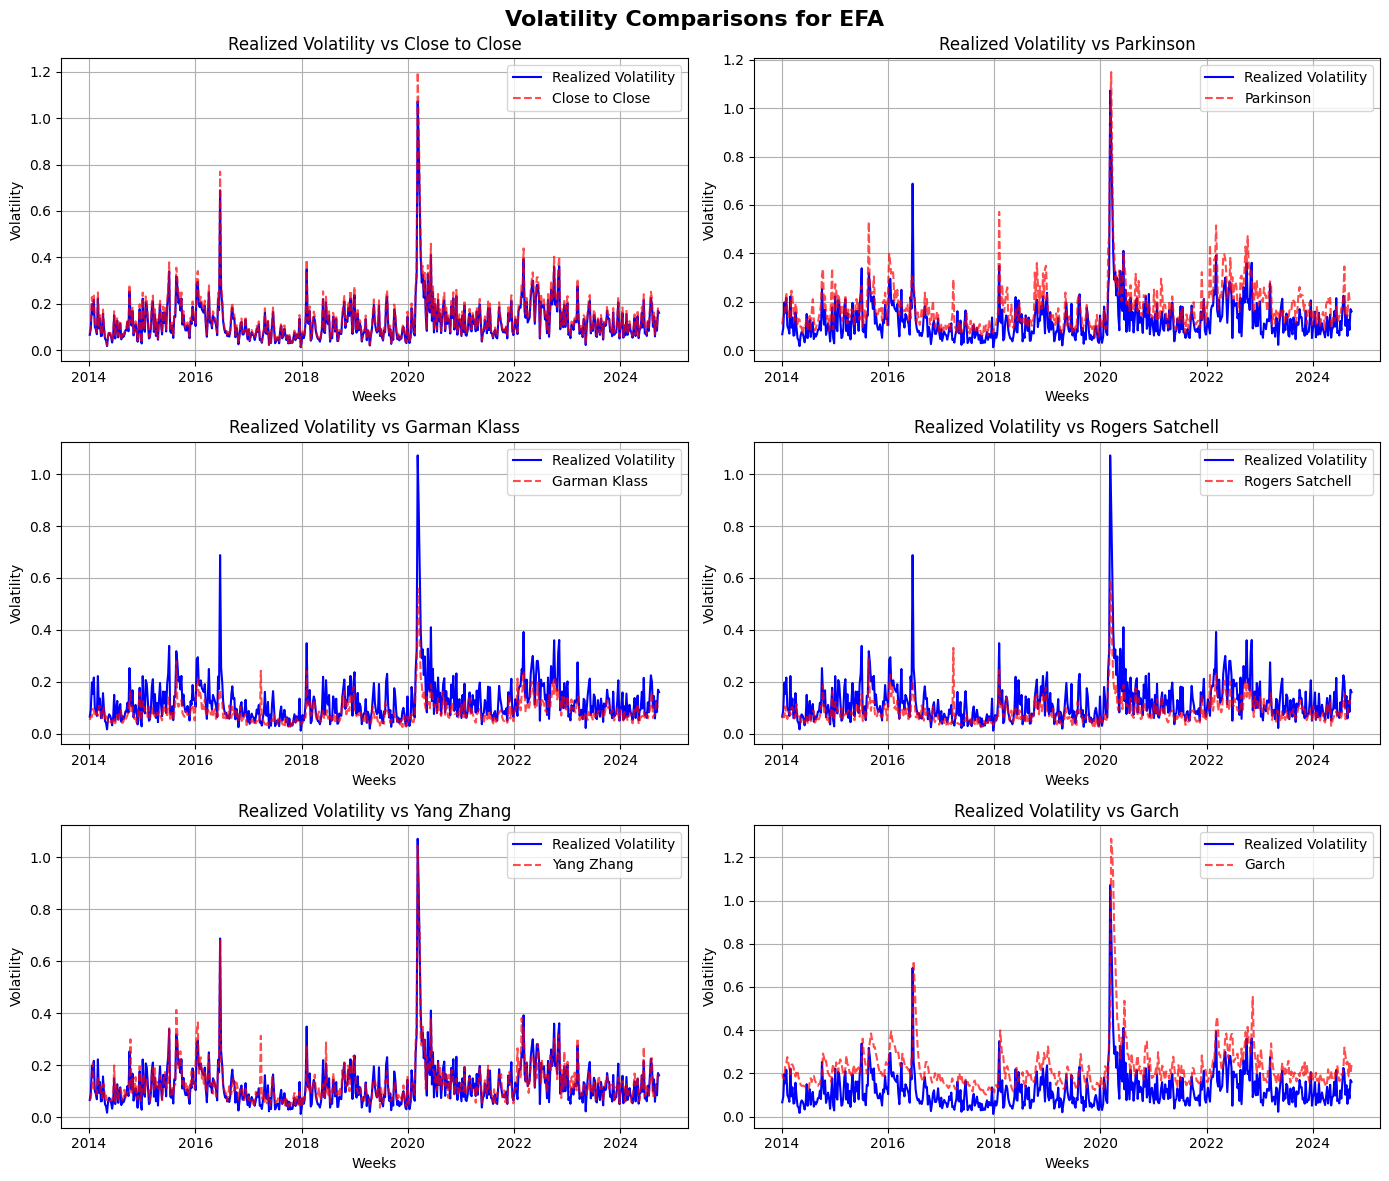

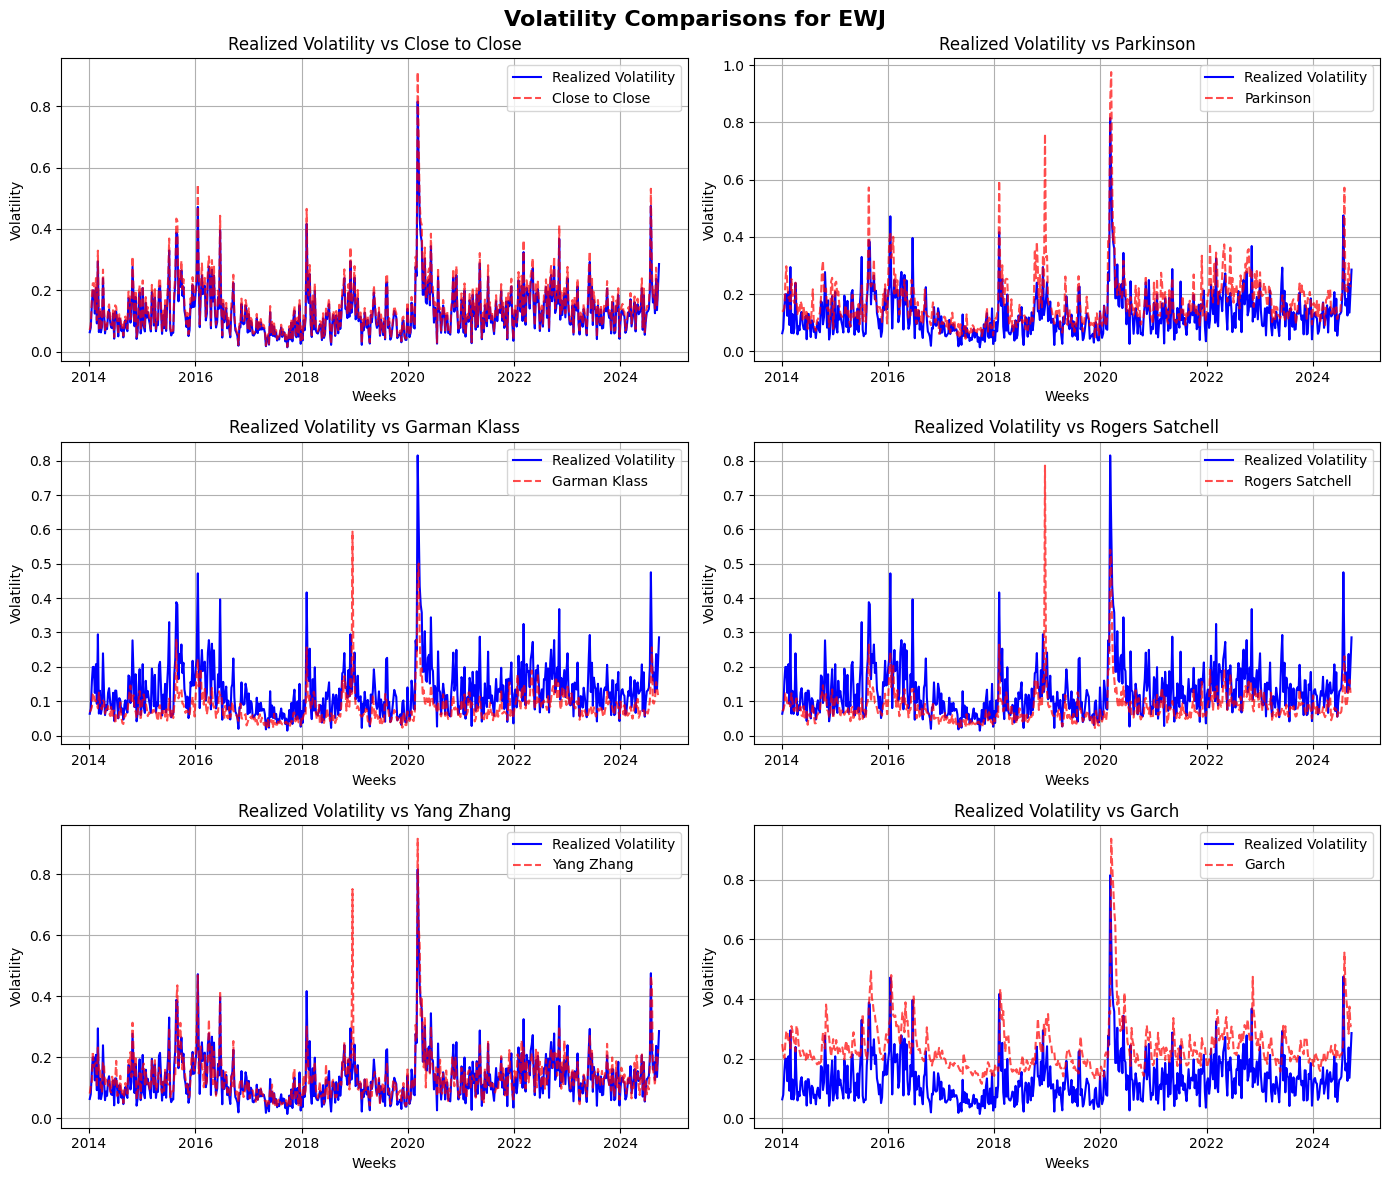

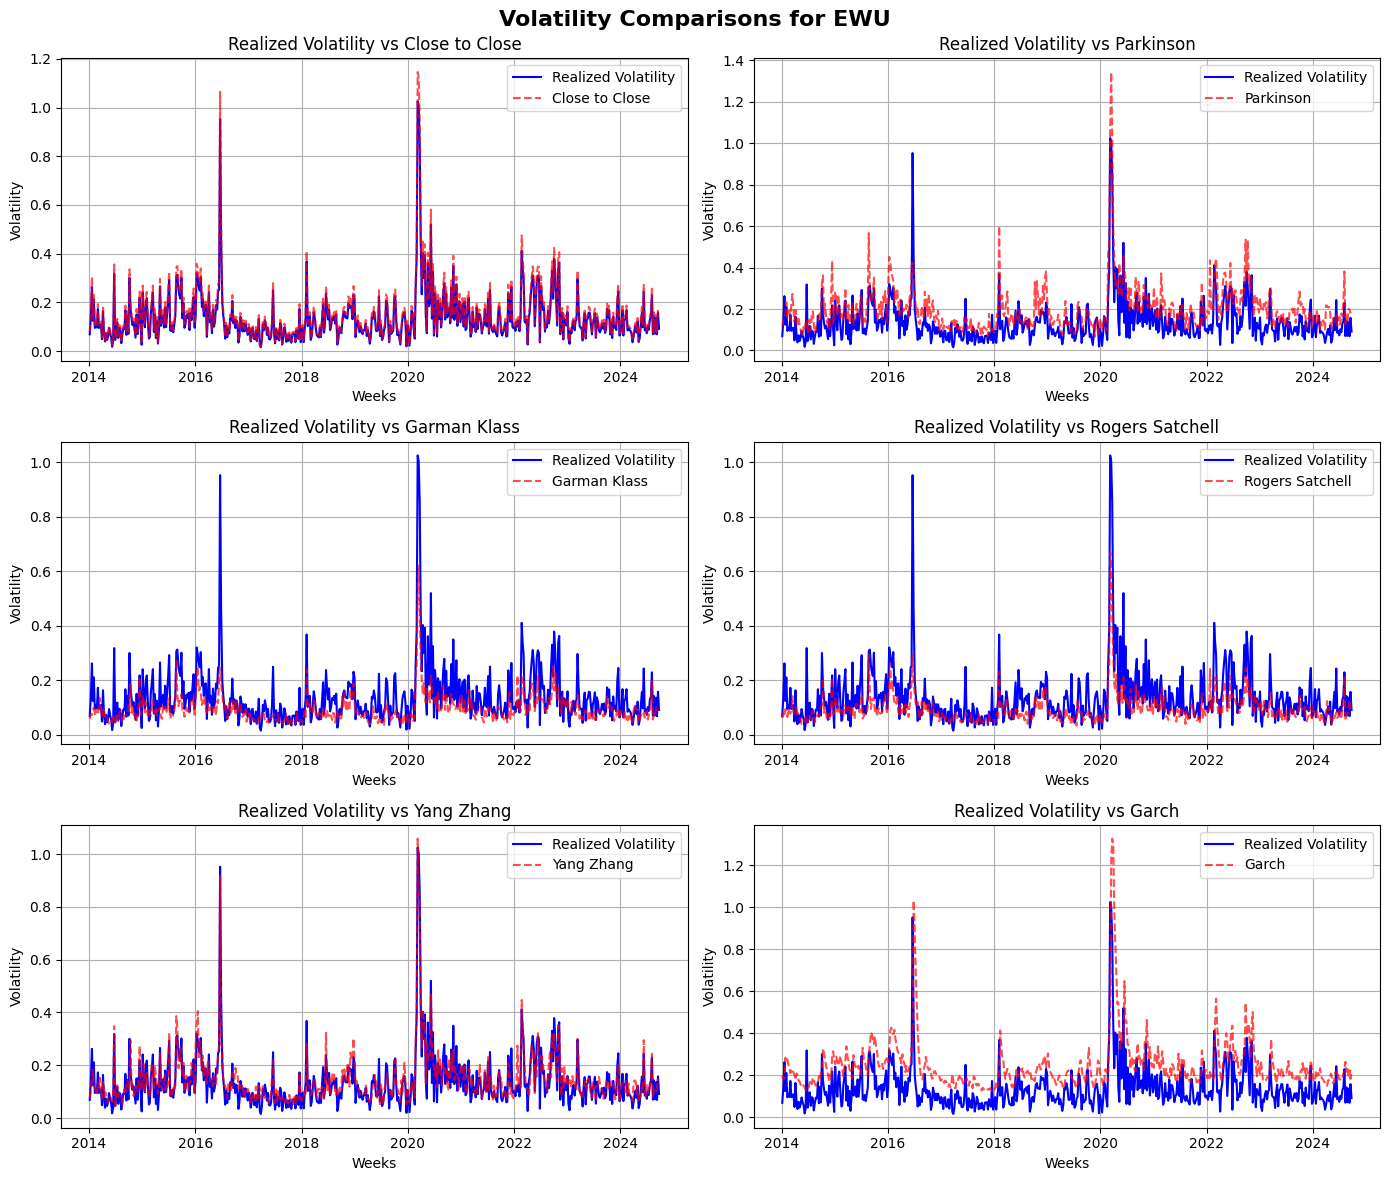

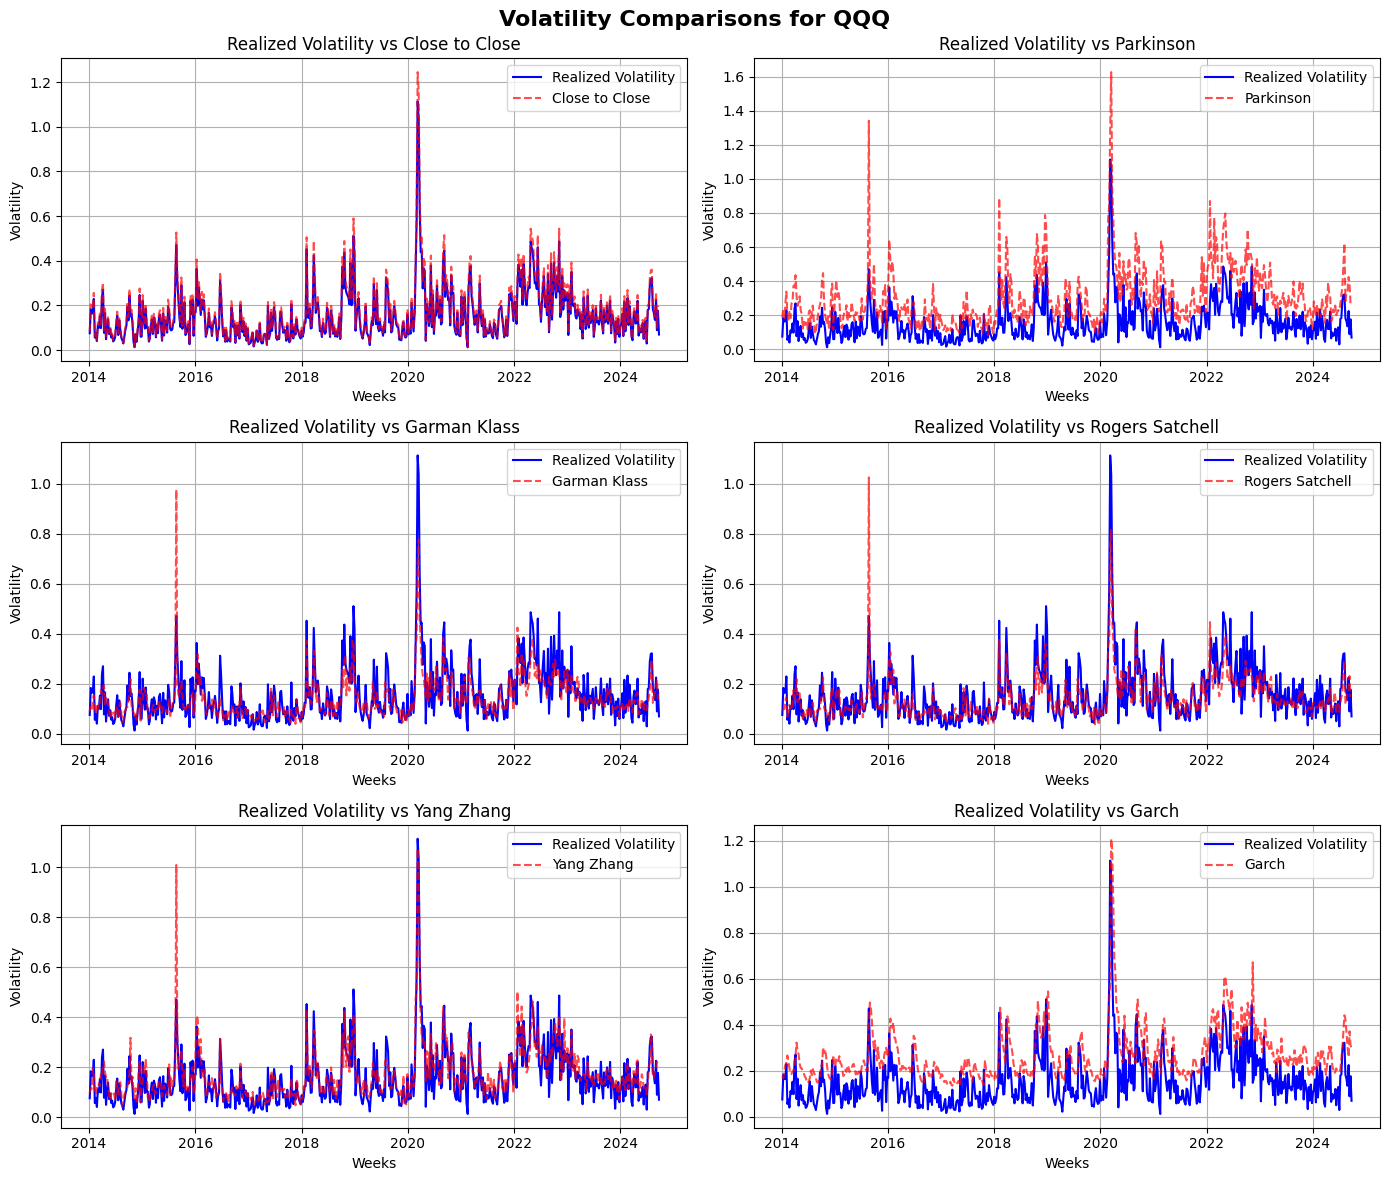

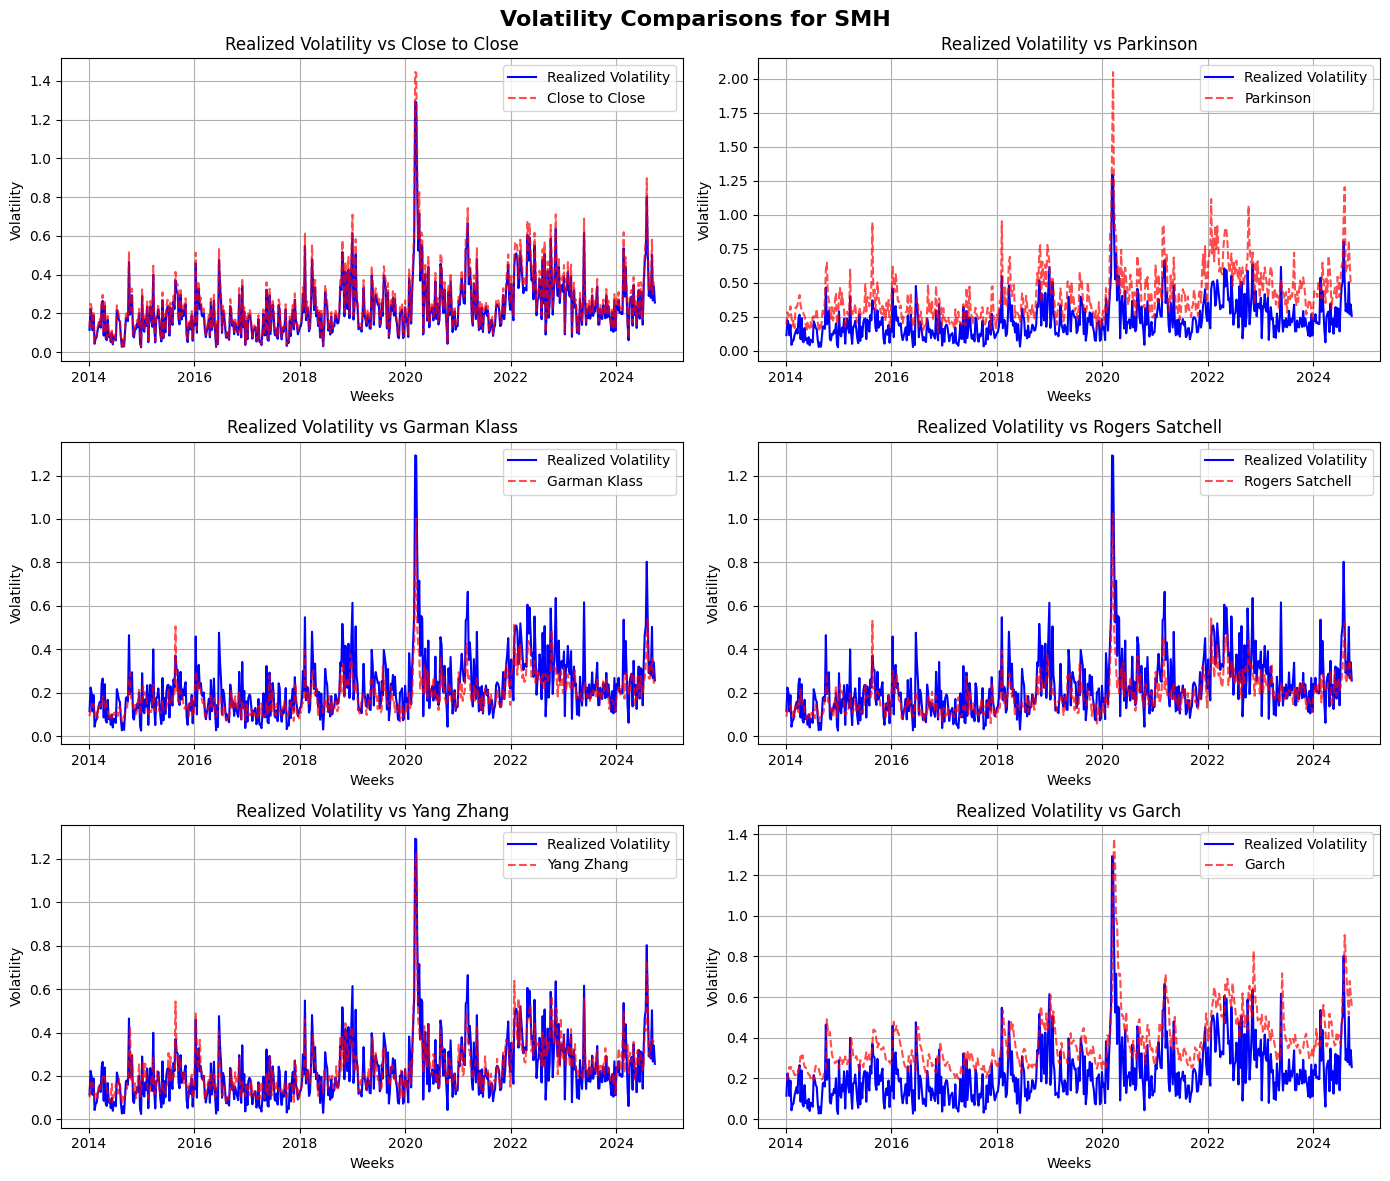

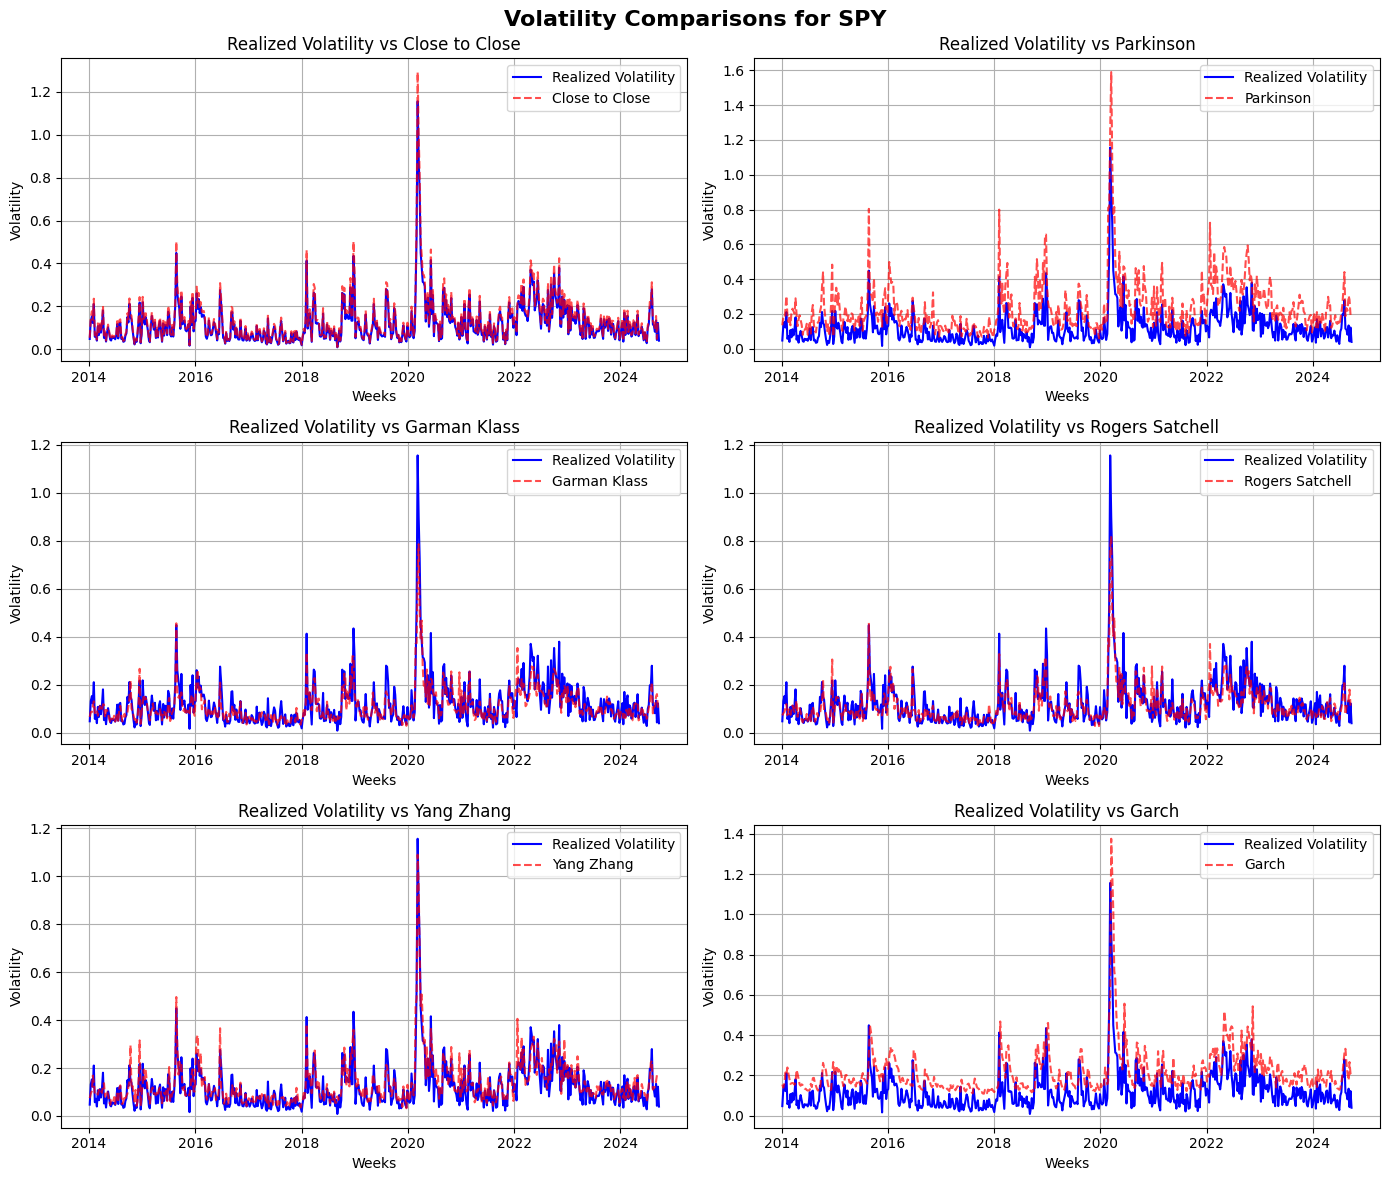

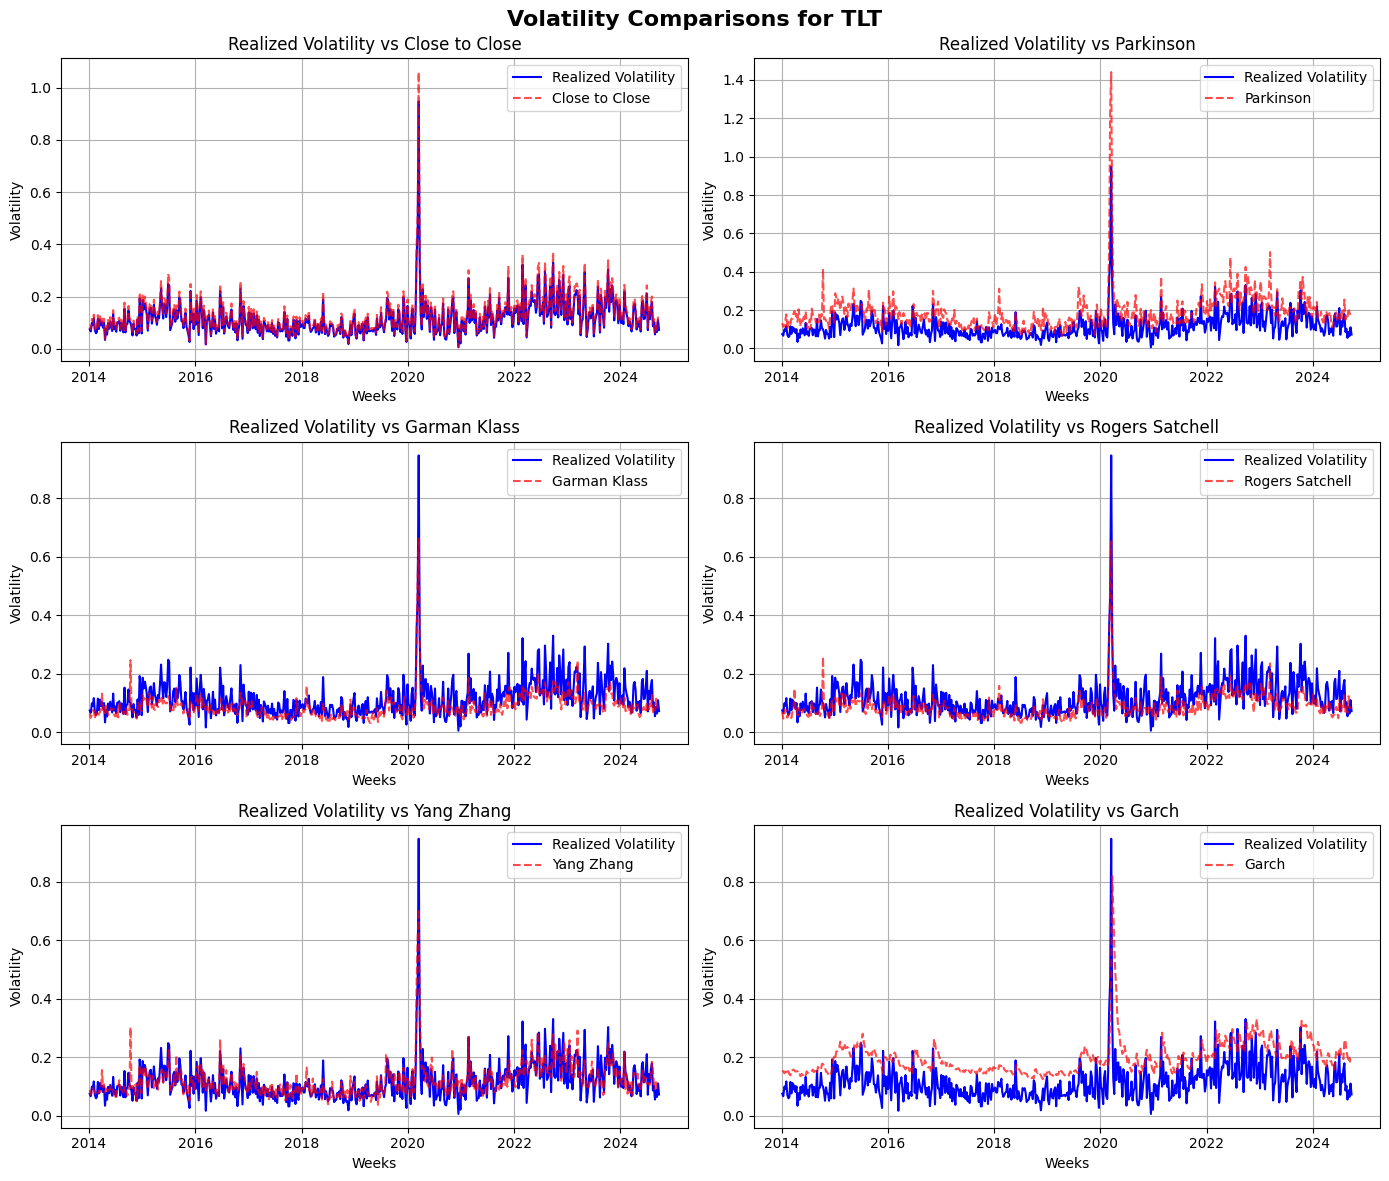

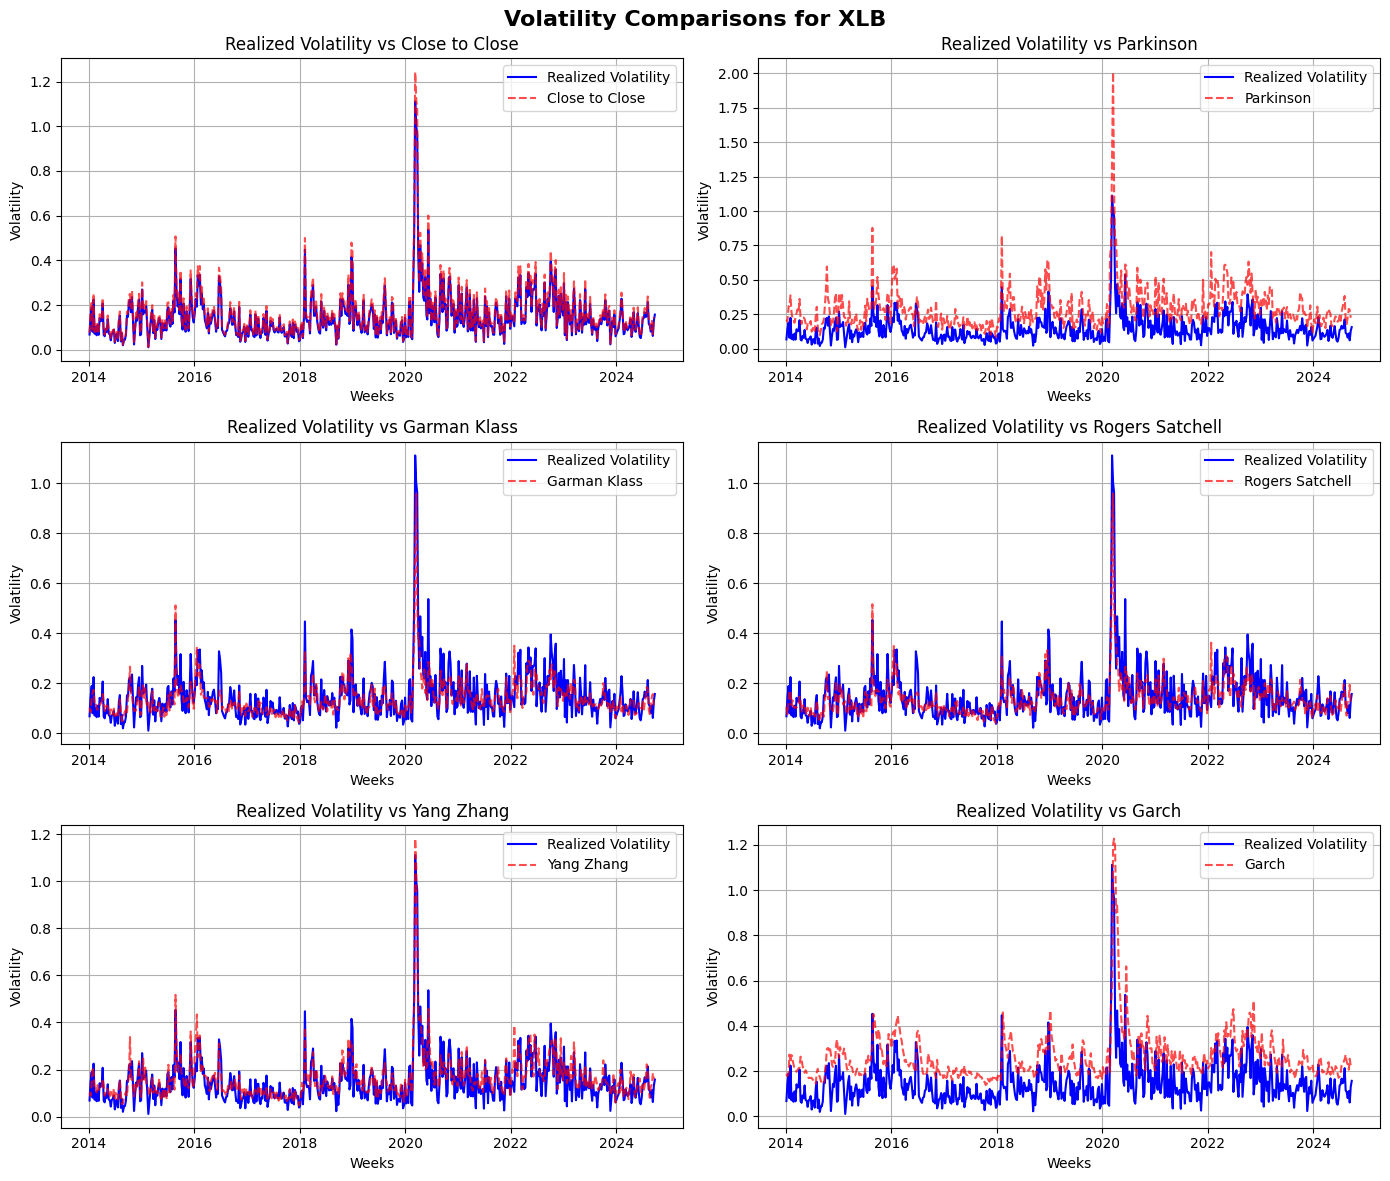

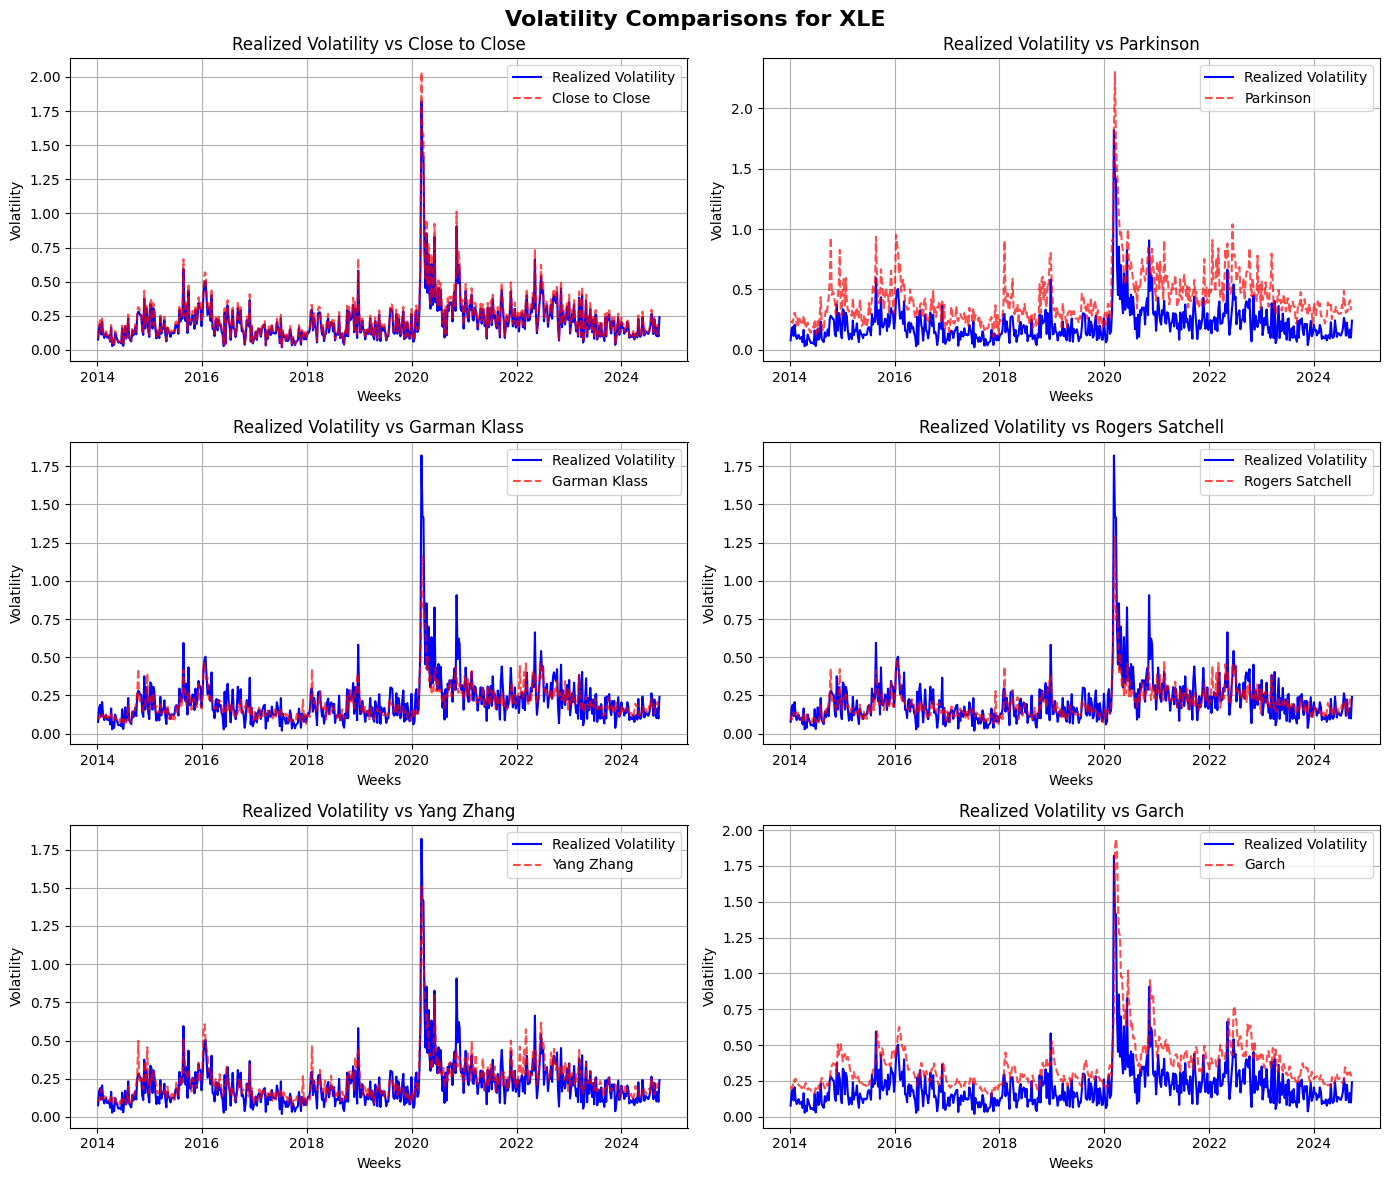

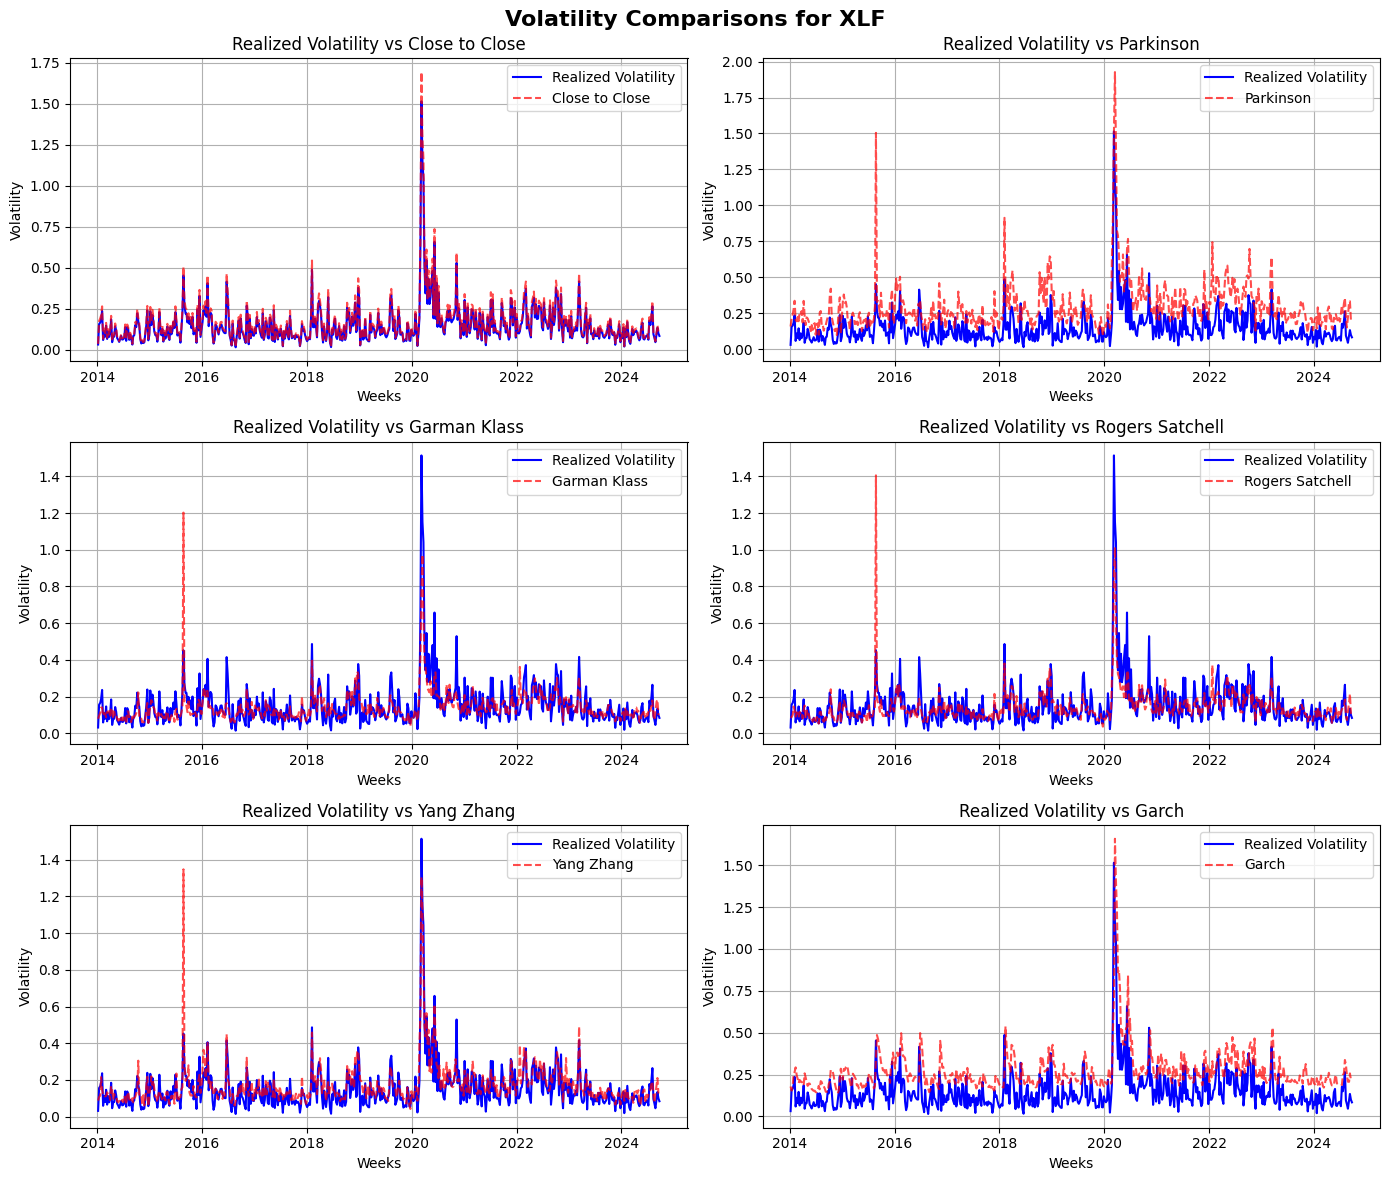

In [56]:
for ETF in ETFs:
    df = etf_volatility_dict[ETF]

    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    
    fig.suptitle(f'Volatility Comparisons for {ETF}', fontsize=16, fontweight='bold')

    axs[0, 0].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[0, 0].plot(df['week_start'],df['close_to_close'], label='Close to Close', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[0, 0].set_title('Realized Volatility vs Close to Close')
    axs[0, 0].set_xlabel('Weeks')
    axs[0, 0].set_ylabel('Volatility')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[0, 1].plot(df['week_start'],df['parkinson'], label='Parkinson', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[0, 1].set_title('Realized Volatility vs Parkinson')
    axs[0, 1].set_xlabel('Weeks')
    axs[0, 1].set_ylabel('Volatility')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[1, 0].plot(df['week_start'],df['garman_klass'], label='Garman Klass', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[1, 0].set_title('Realized Volatility vs Garman Klass')
    axs[1, 0].set_xlabel('Weeks')
    axs[1, 0].set_ylabel('Volatility')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[1, 1].plot(df['week_start'],df['rogers_satchell'], label='Rogers Satchell', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[1, 1].set_title('Realized Volatility vs Rogers Satchell')
    axs[1, 1].set_xlabel('Weeks')
    axs[1, 1].set_ylabel('Volatility')
    axs[1, 1].grid()
    axs[1, 1].legend()

    axs[2, 0].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[2, 0].plot(df['week_start'],df['yang_zhang'], label='Yang Zhang', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[2, 0].set_title('Realized Volatility vs Yang Zhang')
    axs[2, 0].set_xlabel('Weeks')
    axs[2, 0].set_ylabel('Volatility')
    axs[2, 0].grid()
    axs[2, 0].legend()

    axs[2, 1].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[2, 1].plot(df['week_start'],df['Garch'], label='Garch', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[2, 1].set_title('Realized Volatility vs Garch')
    axs[2, 1].set_xlabel('Weeks')
    axs[2, 1].set_ylabel('Volatility')
    axs[2, 1].grid()
    axs[2, 1].legend()


    plt.tight_layout()
    plt.show()

#### R²

The following is the data of R², which I present using data frame, histogram, and box plot respectively.

In [28]:
pd.DataFrame(R_squares)

ETF  R^2_close_to_close  R^2_parkinson  R^2_Graman_Klass  \
0  EFA            0.307325       0.396504          0.393959   
1  EWJ            0.195317       0.291164          0.273792   
2  EWU            0.316771       0.408116          0.422007   
3  QQQ            0.395312       0.479850          0.453656   
4  SMH            0.308790       0.398660          0.415811   
5  SPY            0.442136       0.499611          0.492358   
6  TLT            0.193584       0.347632          0.332554   
7  XLB            0.348414       0.437405          0.441645   
8  XLE            0.384718       0.486679          0.496865   
9  XLF            0.367636       0.414367          0.357651   

   R^2_Rogers_Satchell  R^2_Yang_Zhang  R^2_Garch  
0             0.377902        0.352975   0.343005  
1             0.240486        0.223225   0.255432  
2             0.426270        0.385520   0.341873  
3             0.447007        0.455532   0.453455  
4             0.423699        0.397938   0.369131  
5             0.482859        0.497122   0.488648  
6             0.314806        0.326842   0.211158  
7             0.439037        0.447766   0.399317  
8             0.495676        0.495435   0.480062  
9             0.328085        0.391873   0.422503

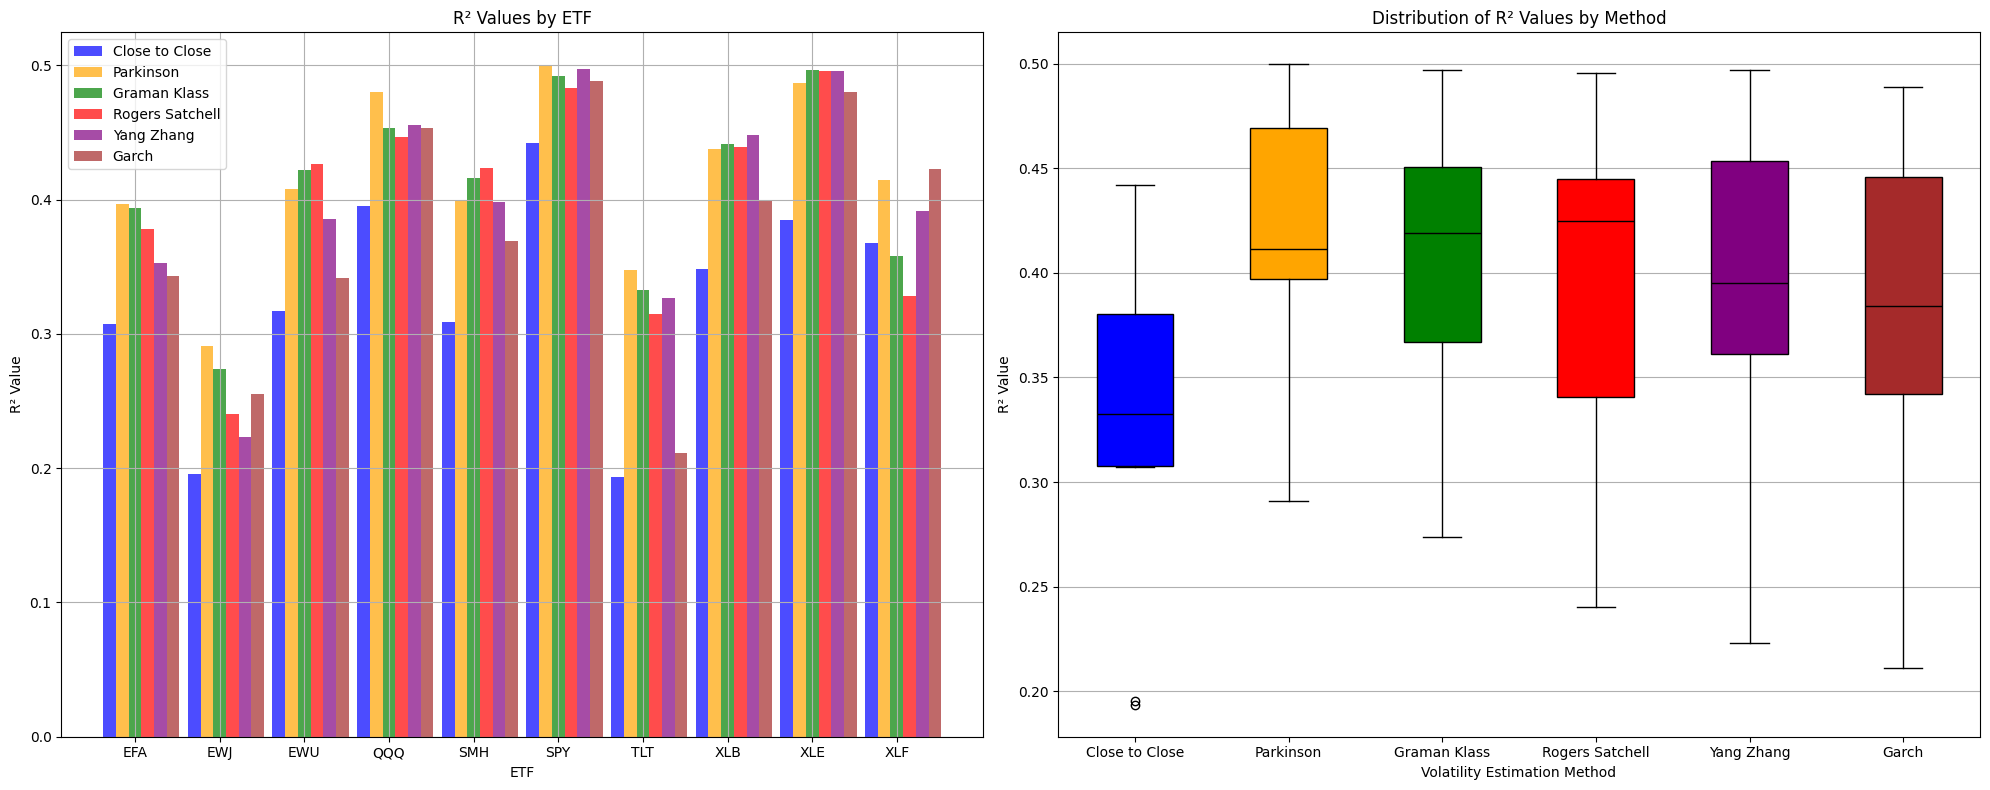

In [41]:
df = pd.DataFrame(R_squares)

# create a 1x2 subplot 
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

x = np.arange(len(df['ETF']))
width = 0.15

axs[0].bar(x - 2 * width, df['R^2_close_to_close'], width, label='Close to Close', alpha=0.7, color='blue')
axs[0].bar(x - width, df['R^2_parkinson'], width, label='Parkinson', alpha=0.7, color='orange')
axs[0].bar(x, df['R^2_Graman_Klass'], width, label='Graman Klass', alpha=0.7, color='green')
axs[0].bar(x + width, df['R^2_Rogers_Satchell'], width, label='Rogers Satchell', alpha=0.7, color='red')
axs[0].bar(x + 2 * width, df['R^2_Yang_Zhang'], width, label='Yang Zhang', alpha=0.7, color='purple')
axs[0].bar(x + 3 * width, df['R^2_Garch'], width, label='Garch', alpha=0.7, color='brown')

axs[0].set_xticks(x)
axs[0].set_xticklabels(df['ETF'])
axs[0].set_title('R² Values by ETF')
axs[0].set_xlabel('ETF')
axs[0].set_ylabel('R² Value')
axs[0].legend()
axs[0].grid()

df_box = df[['R^2_close_to_close', 'R^2_parkinson', 'R^2_Graman_Klass', 'R^2_Rogers_Satchell', 'R^2_Yang_Zhang', 'R^2_Garch']]
df_box.columns = ['Close to Close', 'Parkinson', 'Graman Klass', 'Rogers Satchell', 'Yang Zhang', 'Garch']

box = axs[1].boxplot(df_box.values, tick_labels=df_box.columns, patch_artist=True, medianprops={'color': 'black'})

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

axs[1].set_title('Distribution of R² Values by Method')
axs[1].set_xlabel('Volatility Estimation Method')
axs[1].set_ylabel('R² Value')
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

#### Mean Absolute Error

Mean absolute error (MAE) is a common metric for evaluating the accuracy of regression models. It measures the average absolute difference between predicted and actual values, which indicates how close the prediction is to the actual outcome.

Formula:


\begin{aligned}
\text{Mean Absolute Error (MAE)} &= \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right| \\
\end{aligned}


Where:

- $n$ : Number of observations

- $y_i$ : Actual value for observation

- $\hat{y}_i$ : Predicted value for observation

- $\left| y_i - \hat{y}_i \right|$ : Absolute difference between the actual and predicted values for each observation.

Sice MAE measures absolute differences, it directly reflects the average error without exaggerating larger errors, so it is useful when you want to balance the power of all observations. Unlike metrics such as mean square error (MSE), MAE is less sensitive to large errors. It does not consider the square of the error, but the absolute value of the error, which reduces the impact of extreme values ​​or outliers.

In [42]:
pd.DataFrame(etf_MAE)

ETF  close_to_close  parkinson  Graman_Klass  Rogers_Satchell  Yang_Zhang  \
0  EFA        0.051333   0.046831      0.046946         0.047274    0.049117   
1  EWJ        0.052716   0.047727      0.047931         0.048532    0.050727   
2  EWU        0.056883   0.053284      0.053190         0.053280    0.053729   
3  QQQ        0.064218   0.057579      0.057267         0.057662    0.058890   
4  SMH        0.089873   0.080757      0.080553         0.081047    0.082706   
5  SPY        0.049615   0.045789      0.046026         0.046480    0.046844   
6  TLT        0.041573   0.038721      0.039111         0.039559    0.039504   
7  XLB        0.058131   0.052983      0.053369         0.053962    0.054302   
8  XLE        0.083478   0.072881      0.072131         0.072906    0.074010   
9  XLF        0.064298   0.060751      0.060695         0.061399    0.060894   

      Garch  
0  0.049563  
1  0.049918  
2  0.054559  
3  0.059961  
4  0.084252  
5  0.046268  
6  0.038992  
7  0.055090  
8  0.073740  
9  0.061149

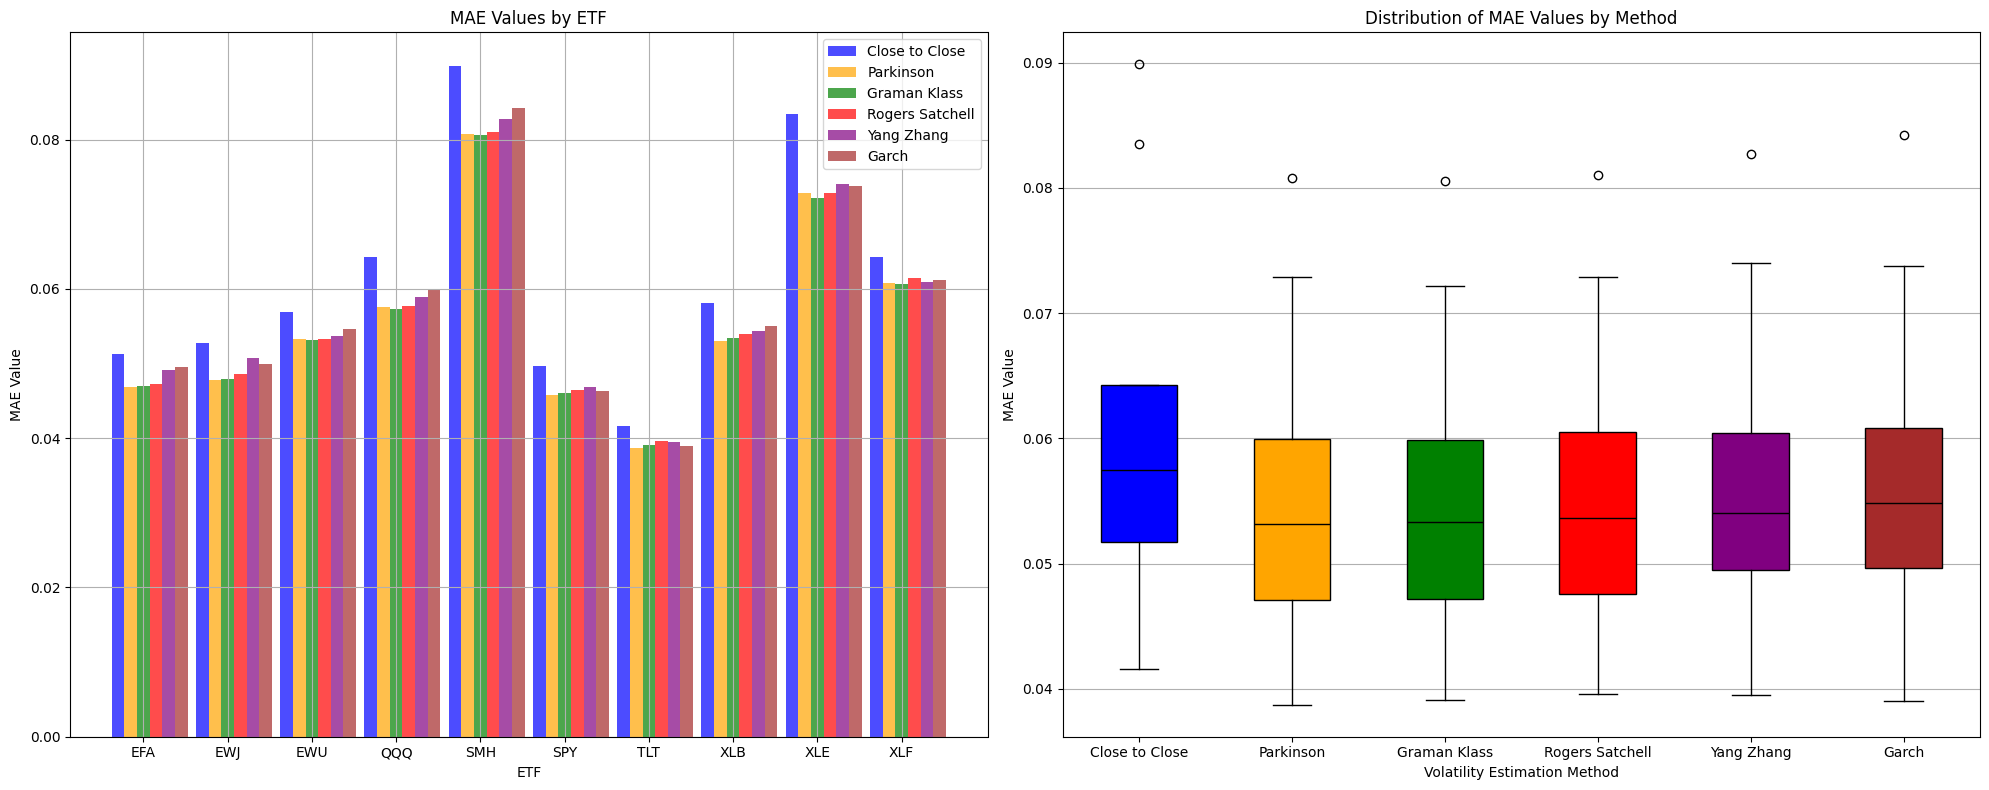

In [44]:
df_MAE = pd.DataFrame(etf_MAE)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

x = np.arange(len(df_MAE['ETF']))
width = 0.15

axs[0].bar(x - 2 * width, df_MAE['close_to_close'], width, label='Close to Close', alpha=0.7, color='blue')
axs[0].bar(x - width, df_MAE['parkinson'], width, label='Parkinson', alpha=0.7, color='orange')
axs[0].bar(x, df_MAE['Graman_Klass'], width, label='Graman Klass', alpha=0.7, color='green')
axs[0].bar(x + width, df_MAE['Rogers_Satchell'], width, label='Rogers Satchell', alpha=0.7, color='red')
axs[0].bar(x + 2 * width, df_MAE['Yang_Zhang'], width, label='Yang Zhang', alpha=0.7, color='purple')
axs[0].bar(x + 3 * width, df_MAE['Garch'], width, label='Garch', alpha=0.7, color='brown')

axs[0].set_xticks(x)
axs[0].set_xticklabels(df_MAE['ETF'])
axs[0].set_title('MAE Values by ETF')
axs[0].set_xlabel('ETF')
axs[0].set_ylabel('MAE Value')
axs[0].legend()
axs[0].grid()

df_mae_box = df_MAE[['close_to_close', 'parkinson', 'Graman_Klass', 'Rogers_Satchell', 'Yang_Zhang', 'Garch']]
df_mae_box.columns = ['Close to Close', 'Parkinson', 'Graman Klass', 'Rogers Satchell', 'Yang Zhang', 'Garch']

box = axs[1].boxplot(df_mae_box.values, patch_artist=True, tick_labels=df_mae_box.columns, medianprops={'color': 'black'})

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

axs[1].set_title('Distribution of MAE Values by Method')
axs[1].set_xlabel('Volatility Estimation Method')
axs[1].set_ylabel('MAE Value')
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()


#### Prediction vs Realized Volatility

Finally, let’s take a look at the comparison of realized vol vs predictions for each ETF.

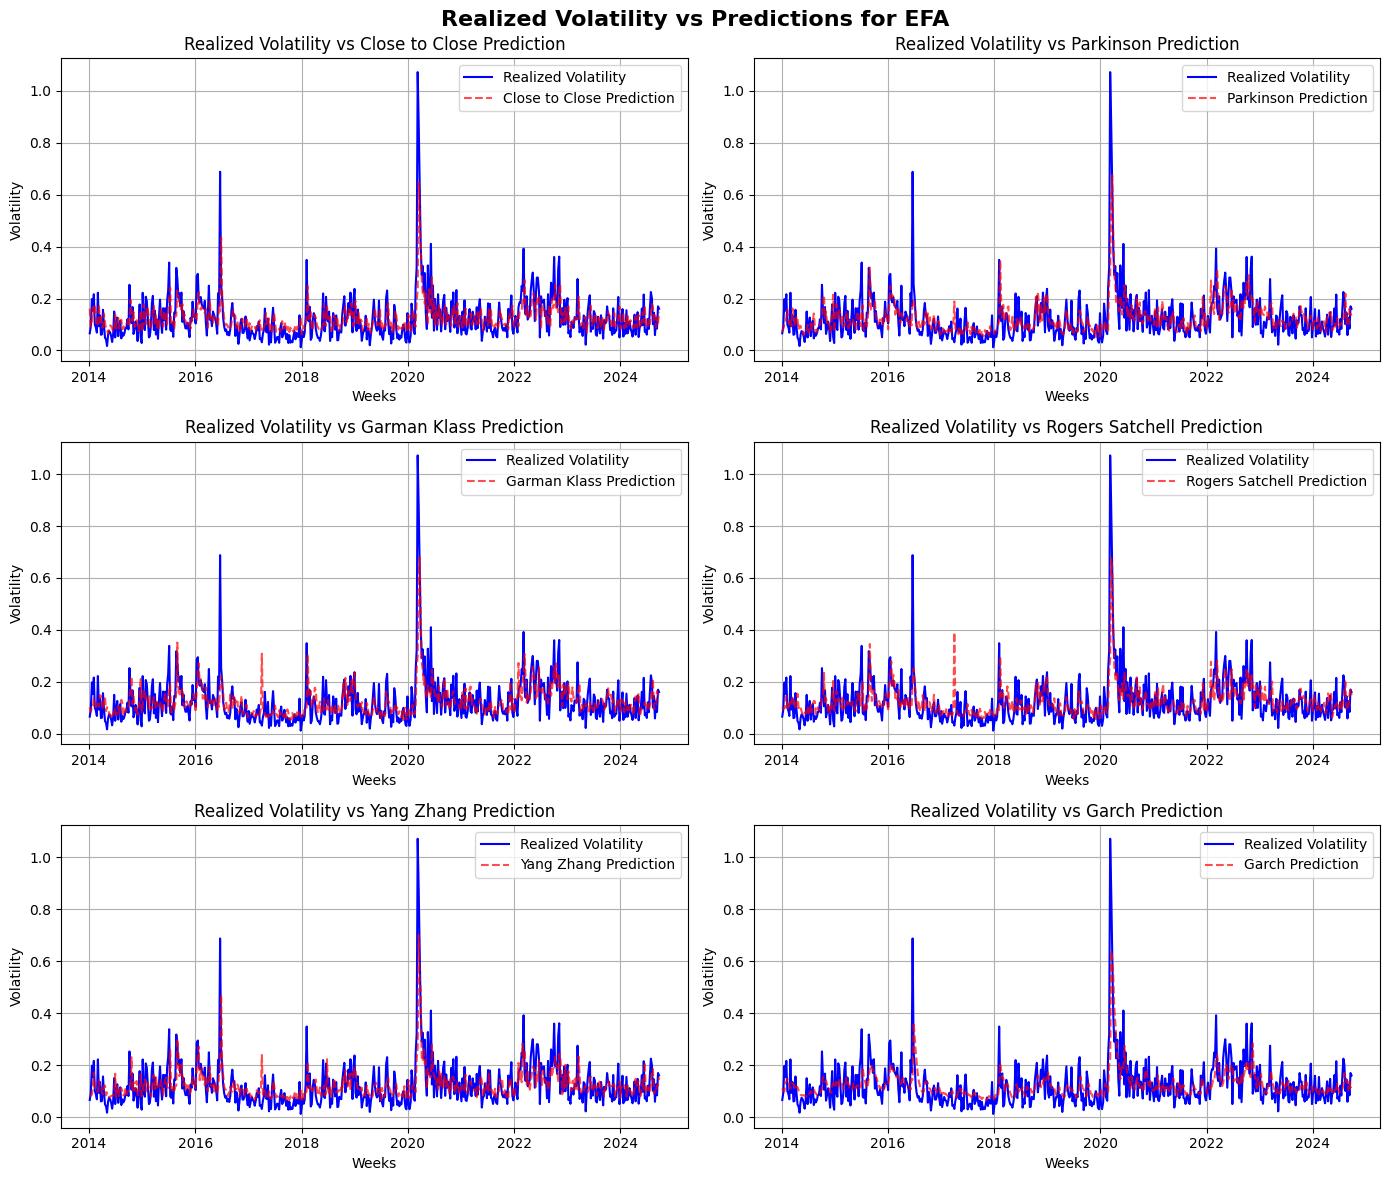

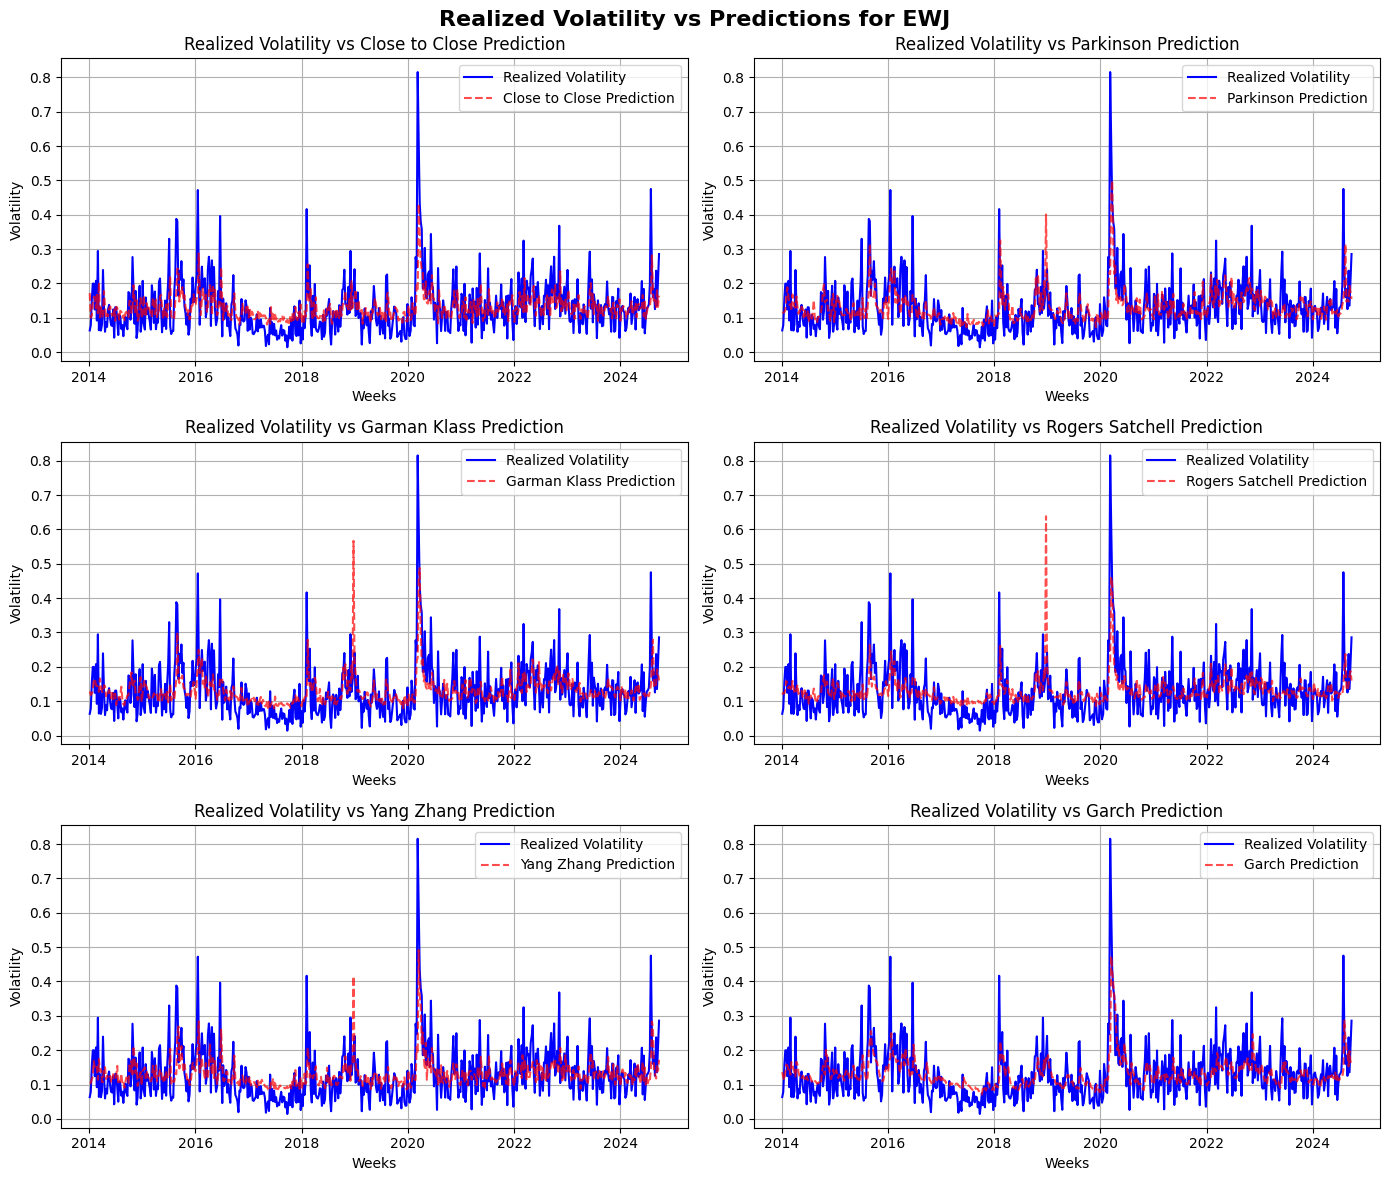

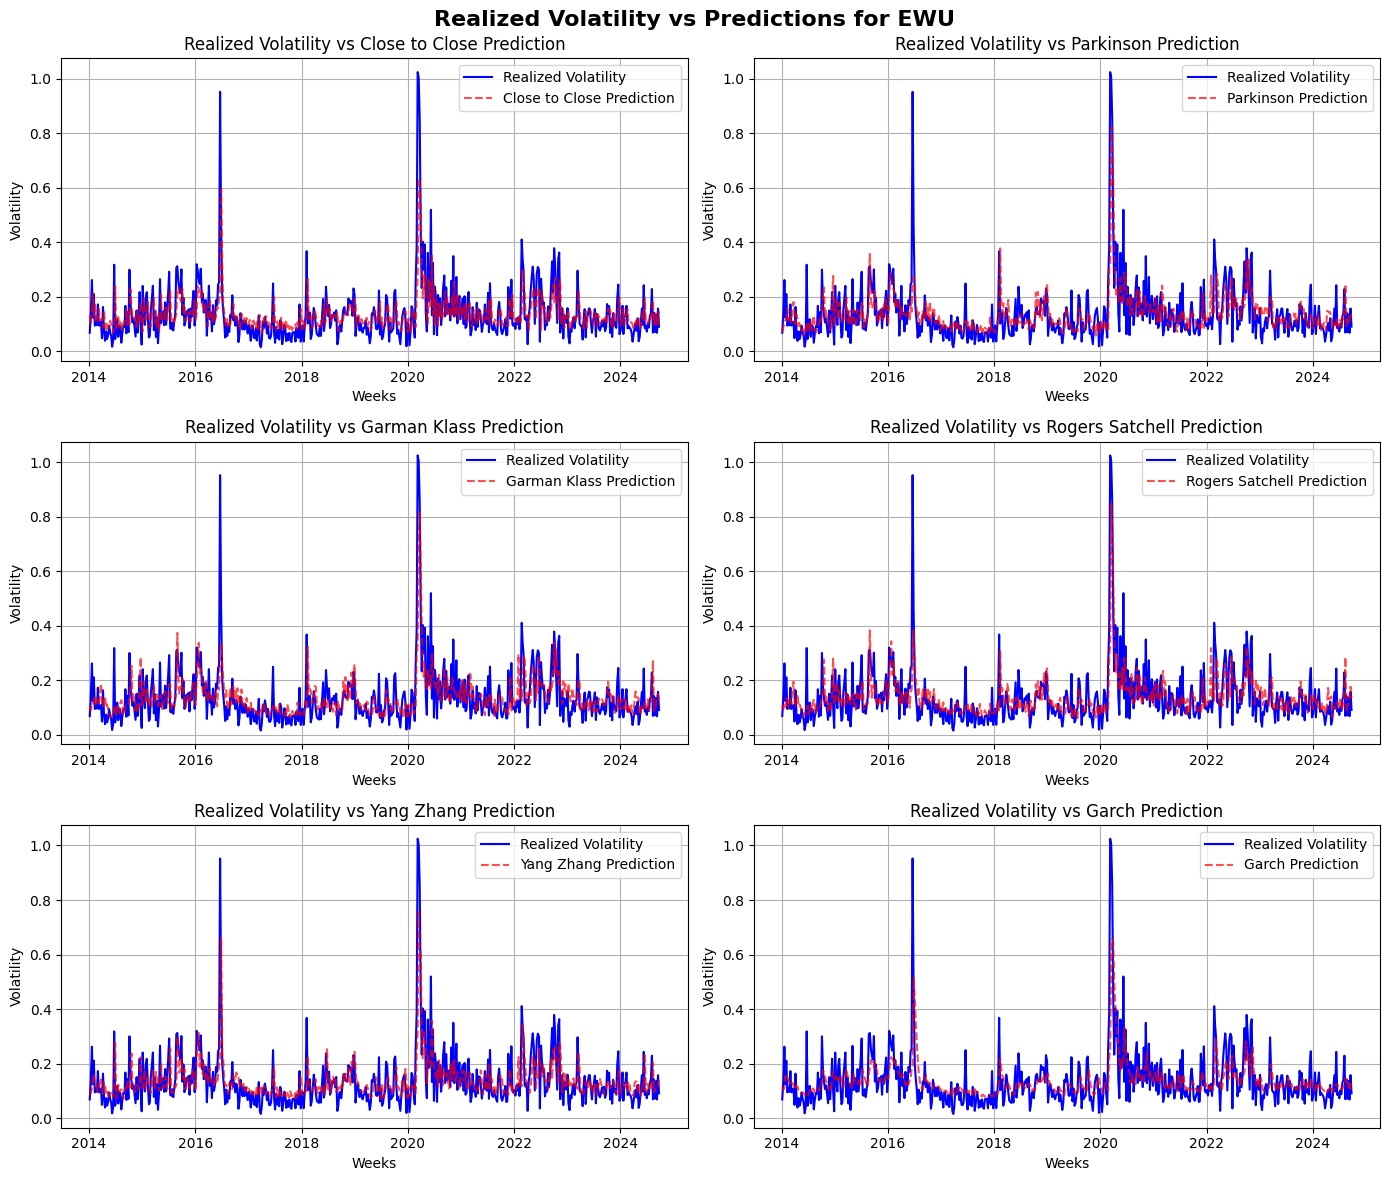

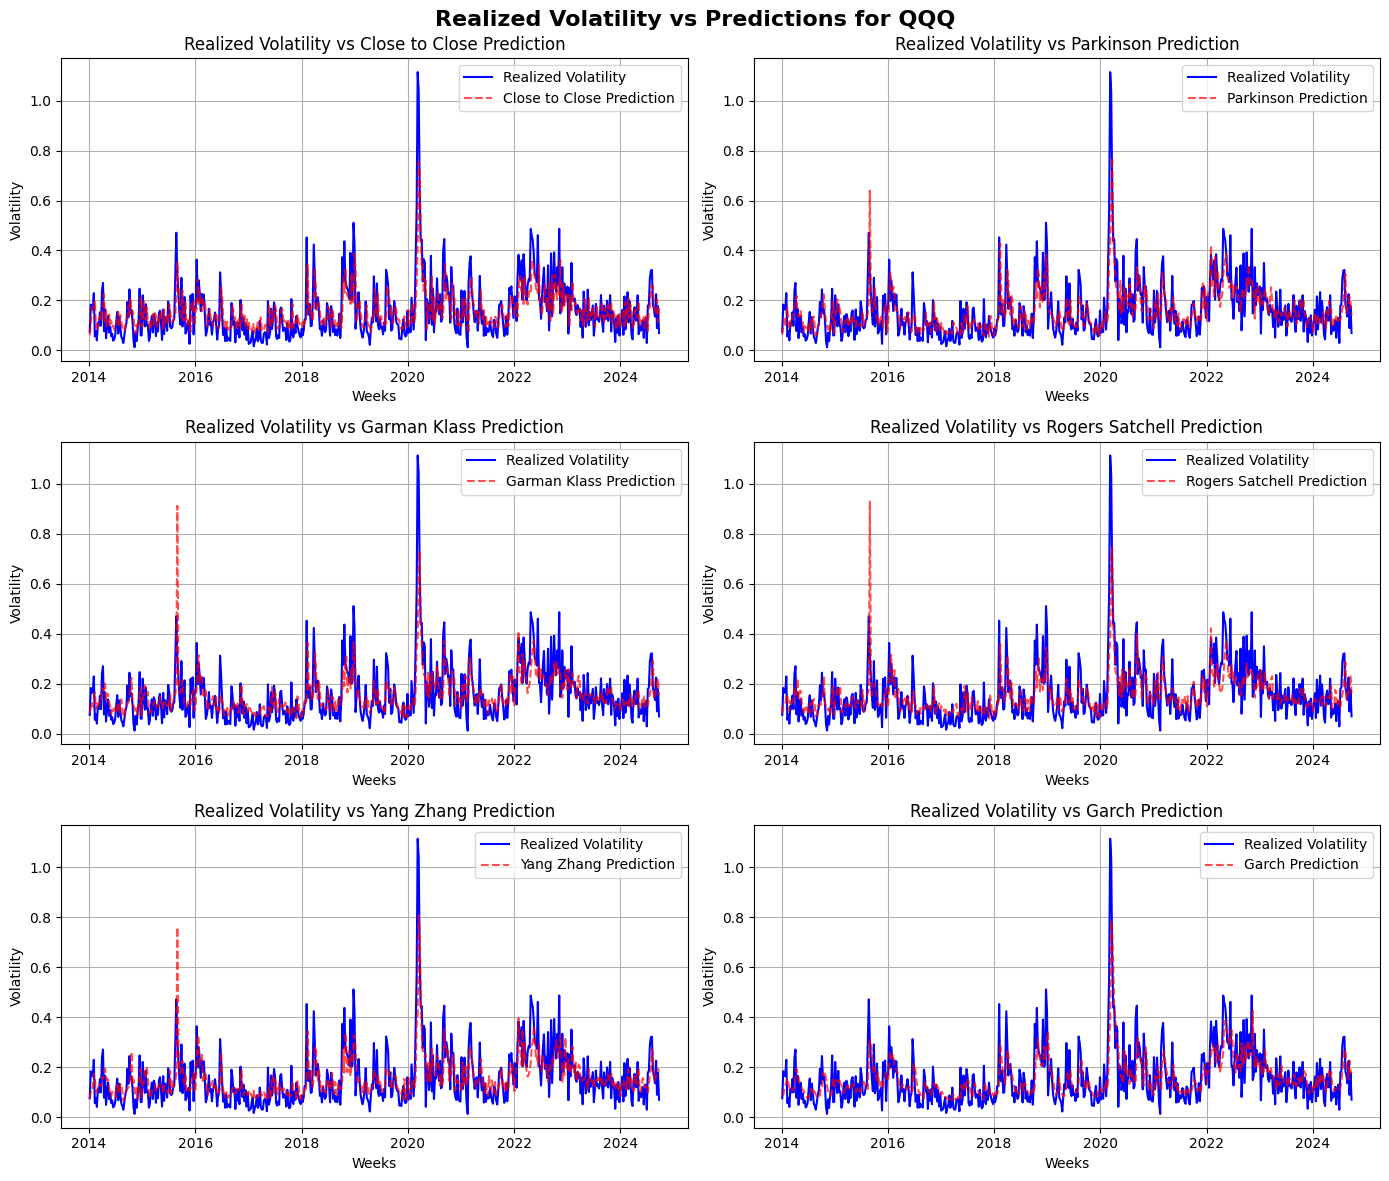

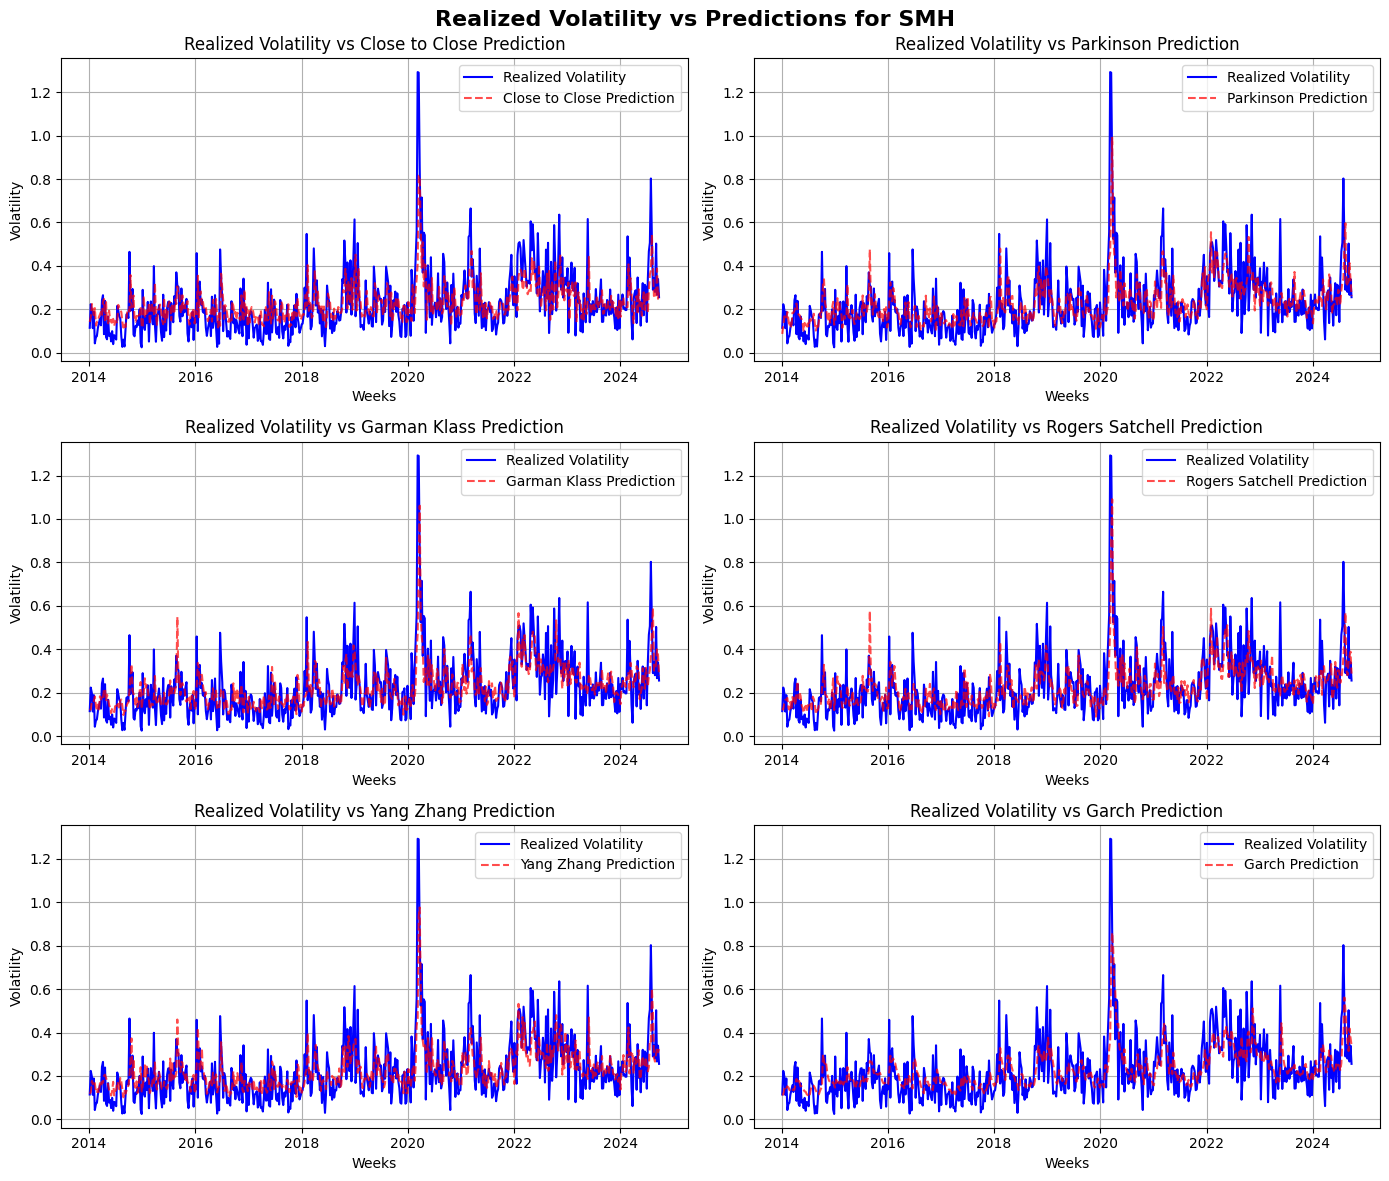

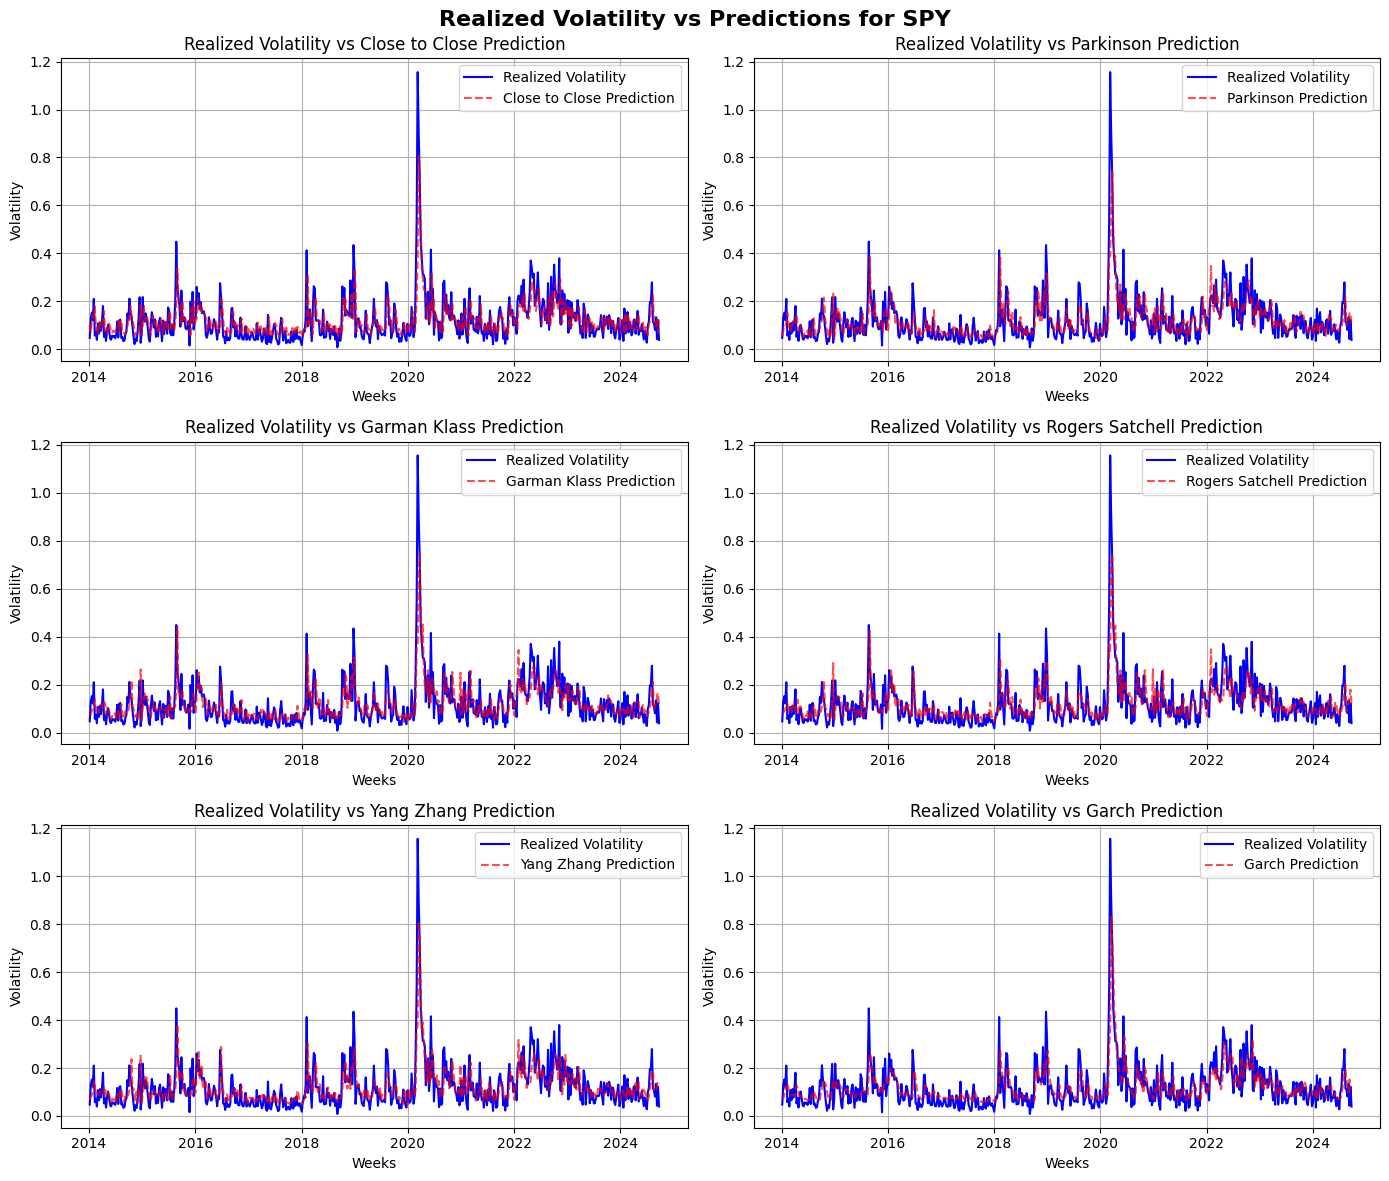

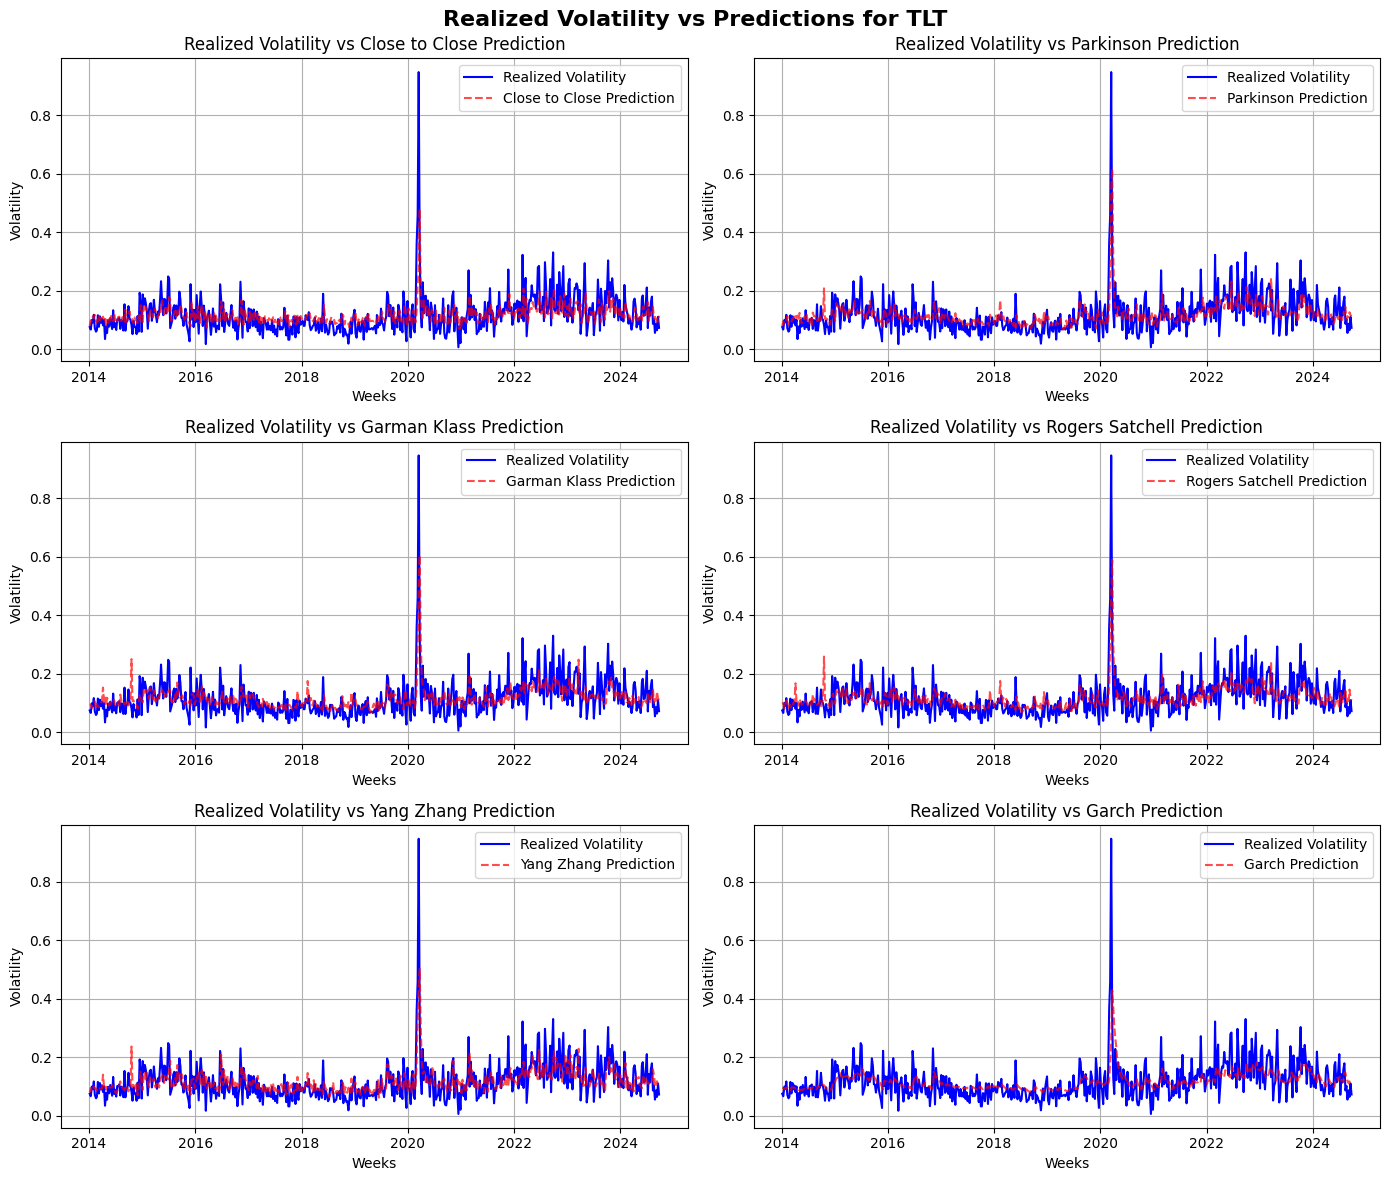

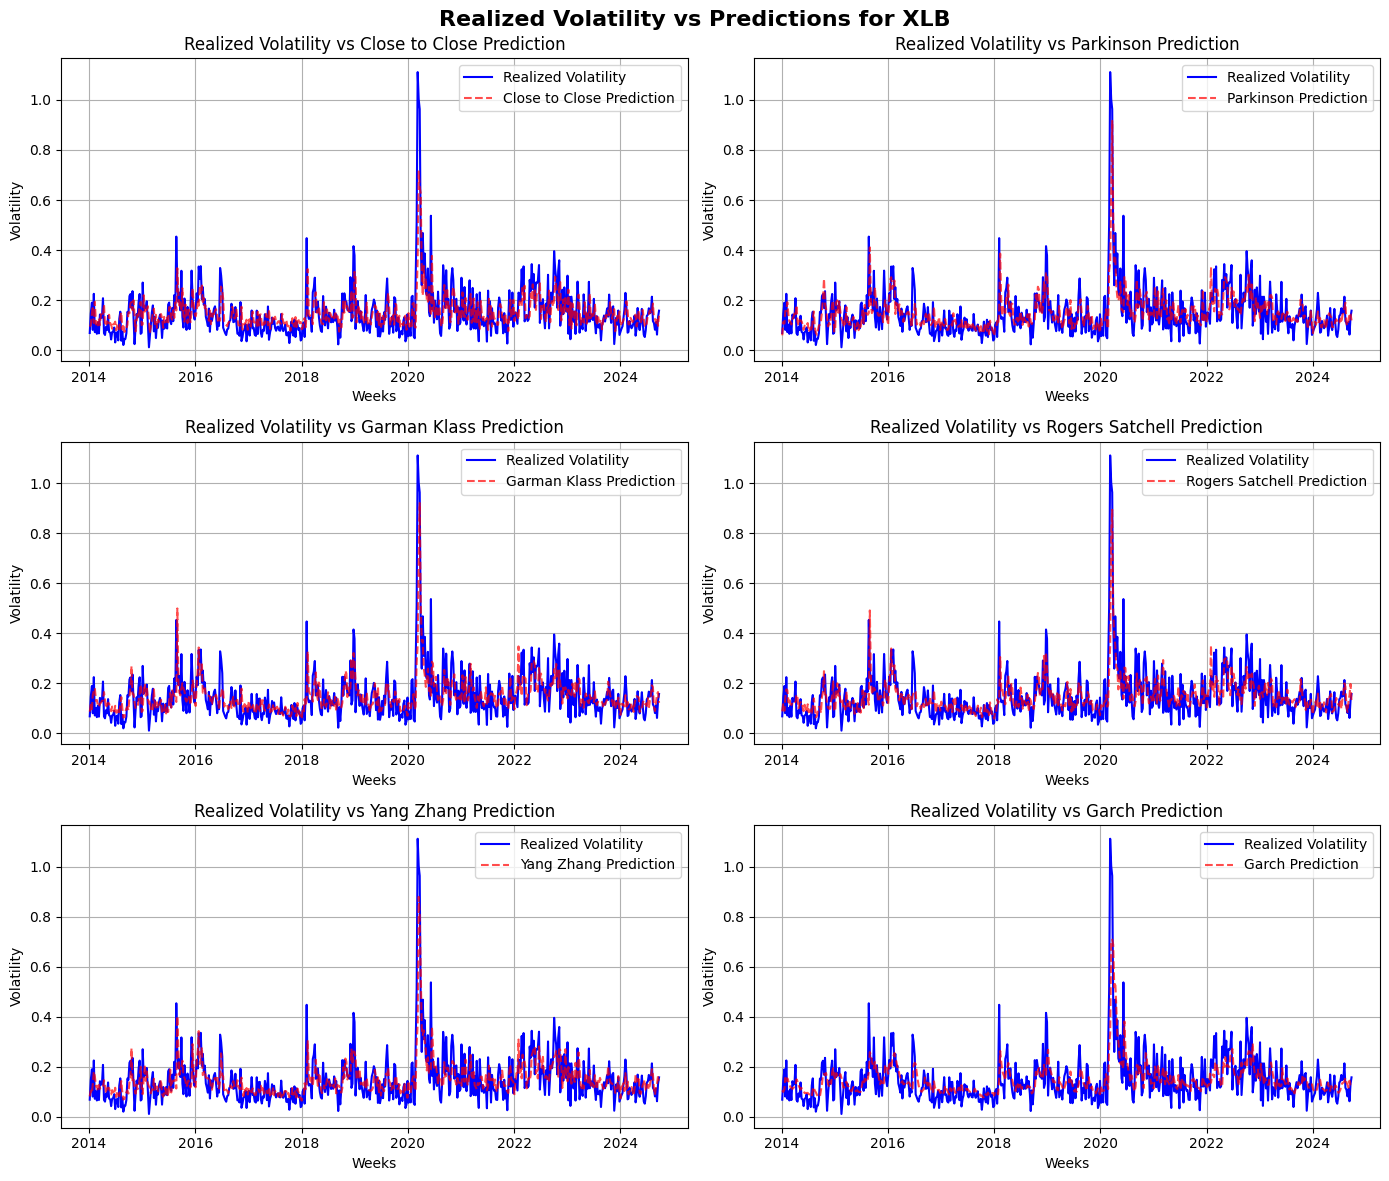

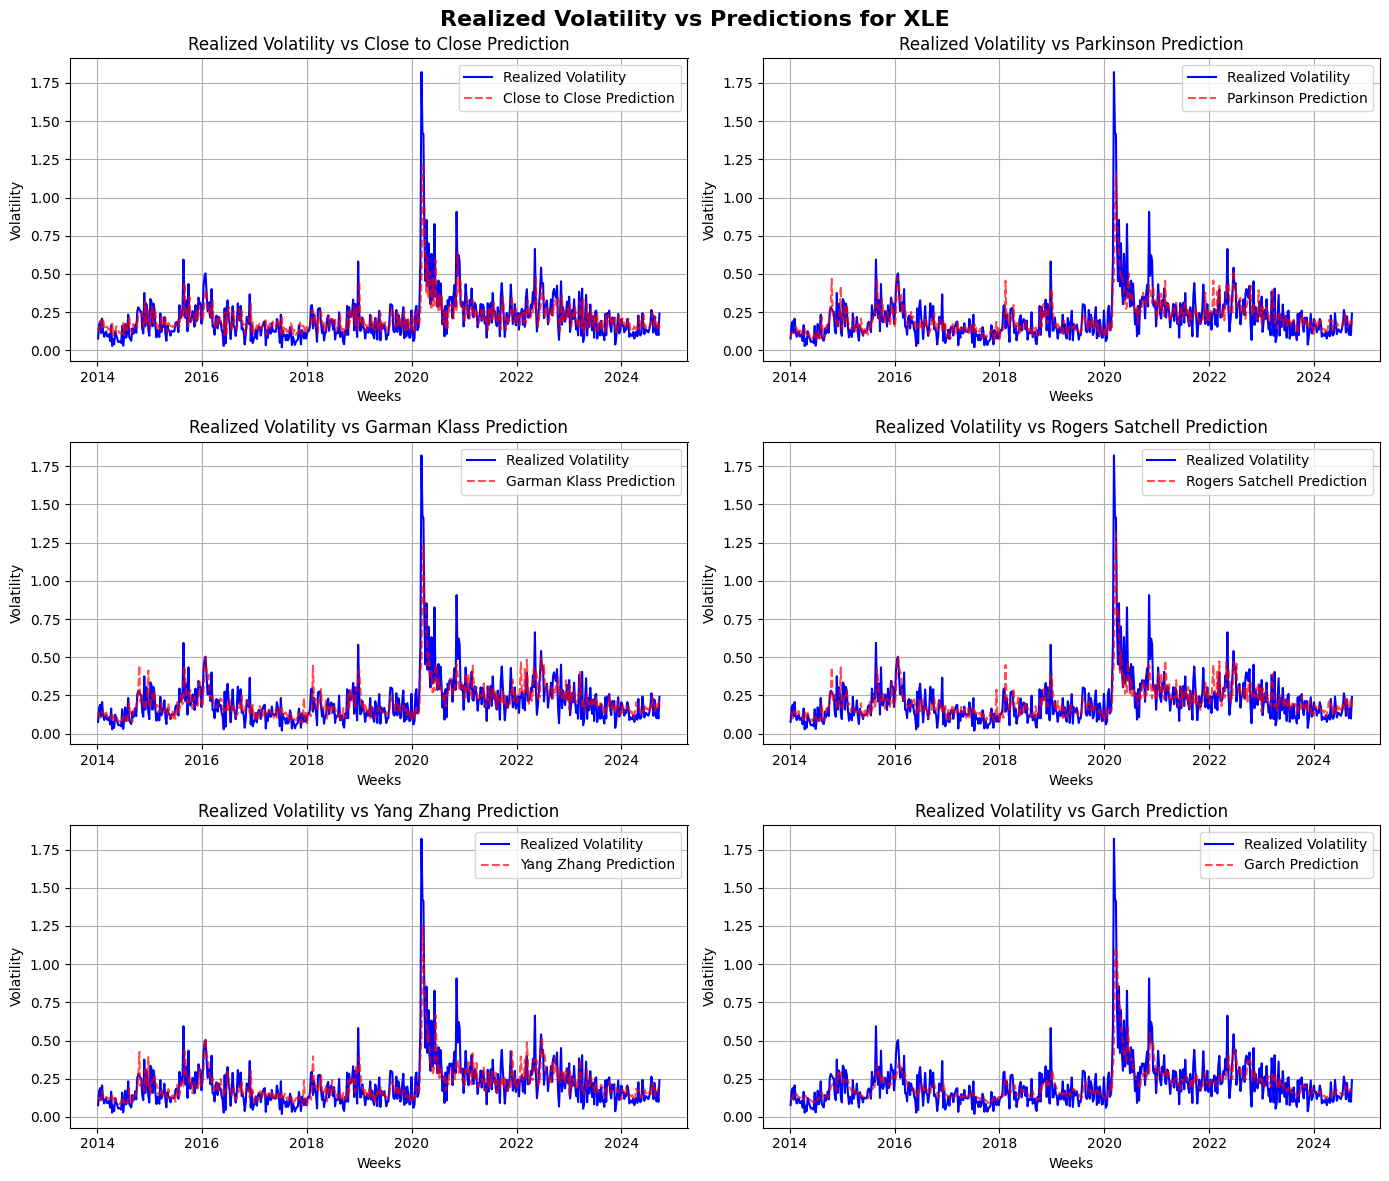

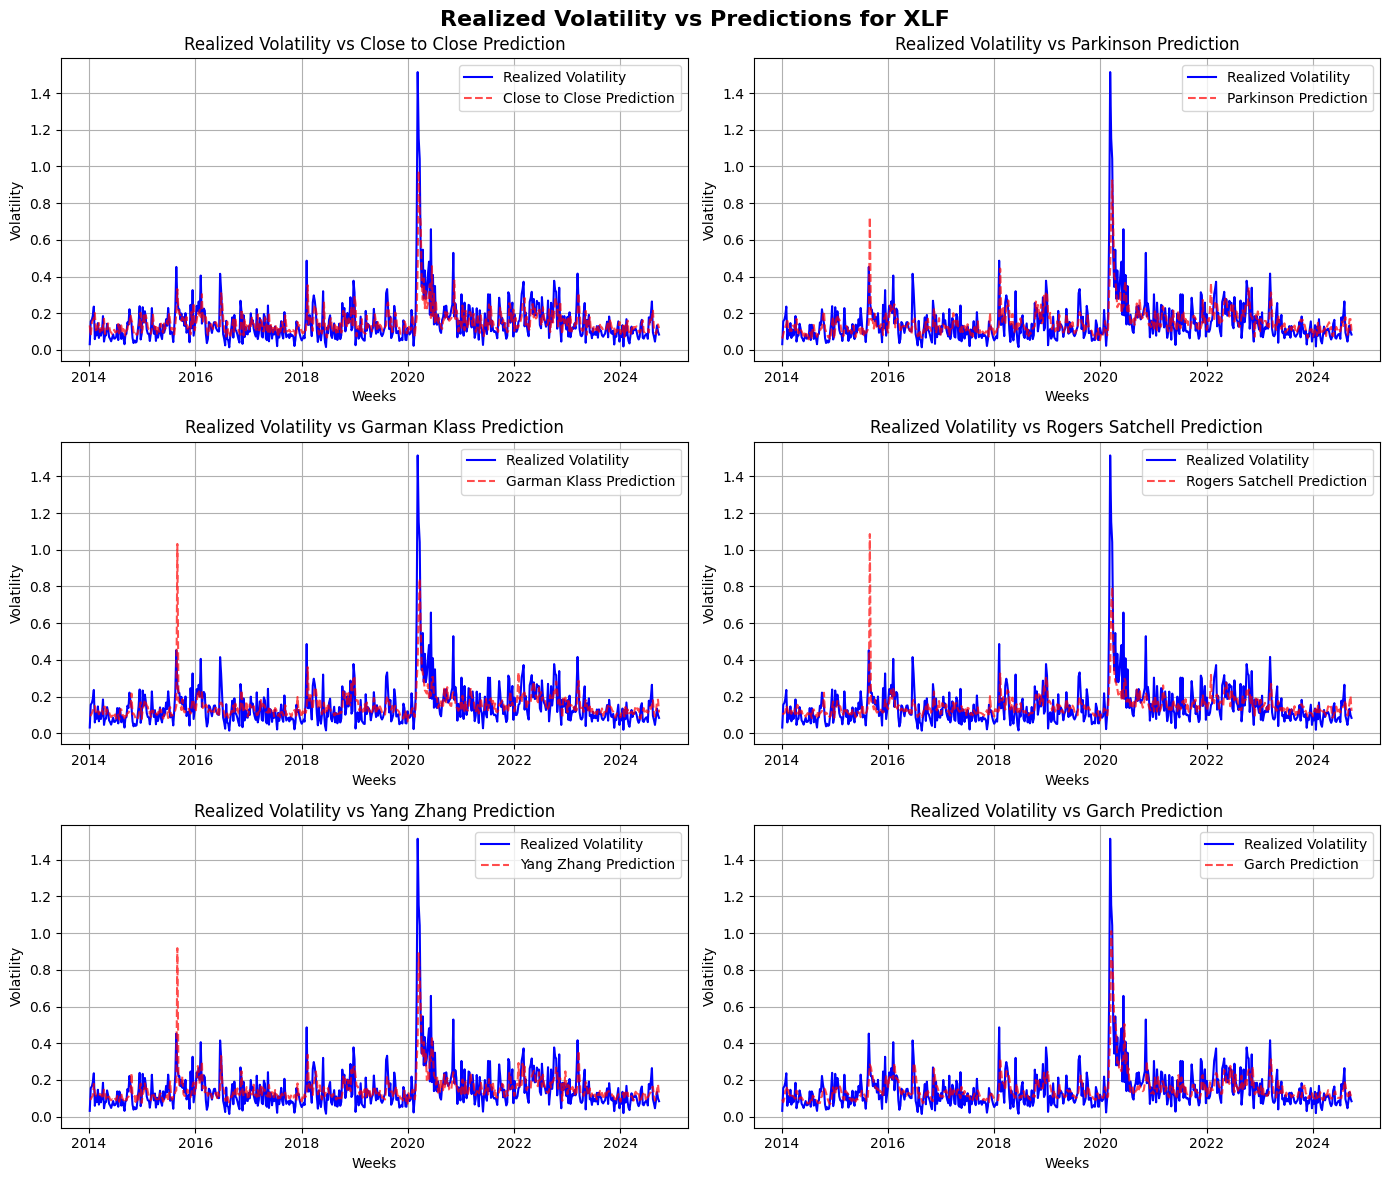

In [59]:
for ETF in ETFs:
    df = prediction[ETF]

    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    
    fig.suptitle(f'Realized Volatility vs Predictions for {ETF}', fontsize=16, fontweight='bold')

    axs[0, 0].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[0, 0].plot(df['week_start'],df['pred_close_to_close'], label='Close to Close Prediction', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[0, 0].set_title('Realized Volatility vs Close to Close Prediction')
    axs[0, 0].set_xlabel('Weeks')
    axs[0, 0].set_ylabel('Volatility')
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[0, 1].plot(df['week_start'],df['pred_parkinson'], label='Parkinson Prediction', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[0, 1].set_title('Realized Volatility vs Parkinson Prediction')
    axs[0, 1].set_xlabel('Weeks')
    axs[0, 1].set_ylabel('Volatility')
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[1, 0].plot(df['week_start'],df['pred_garman_klass'], label='Garman Klass Prediction', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[1, 0].set_title('Realized Volatility vs Garman Klass Prediction')
    axs[1, 0].set_xlabel('Weeks')
    axs[1, 0].set_ylabel('Volatility')
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[1, 1].plot(df['week_start'],df['pred_rogers_satchell'], label='Rogers Satchell Prediction', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[1, 1].set_title('Realized Volatility vs Rogers Satchell Prediction')
    axs[1, 1].set_xlabel('Weeks')
    axs[1, 1].set_ylabel('Volatility')
    axs[1, 1].grid()
    axs[1, 1].legend()

    axs[2, 0].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[2, 0].plot(df['week_start'],df['pred_yang_zhang'], label='Yang Zhang Prediction', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[2, 0].set_title('Realized Volatility vs Yang Zhang Prediction')
    axs[2, 0].set_xlabel('Weeks')
    axs[2, 0].set_ylabel('Volatility')
    axs[2, 0].grid()
    axs[2, 0].legend()

    axs[2, 1].plot(df['week_start'],df['realized_vol'], label='Realized Volatility', color='blue', linewidth=1.5)
    axs[2, 1].plot(df['week_start'],df['pred_garch'], label='Garch Prediction', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axs[2, 1].set_title('Realized Volatility vs Garch Prediction')
    axs[2, 1].set_xlabel('Weeks')
    axs[2, 1].set_ylabel('Volatility')
    axs[2, 1].grid()
    axs[2, 1].legend()


    plt.tight_layout()
    plt.show()

#### Analysis

Based on the R² and Mean Absolute Error (MAE), both the Parkinson and Garman-Klass estimators demonstrate slightly better performance compared to the other estimators in general. Furthermore, the performance of the Parkinson and Garman Klass estimators are relatively close to each other. However, there can be instances of overestimation or underestimation in extreme situations. In such cases, referring to other estimators may provide a more reliable and conservative approach. For example, the Parkinson and Garman Klass are more suitable for stable trading days, whereas the Yang-Zhang performs better in handling opening gaps and overnight jumps.

## **Reference**

18_close_to_close - Pritam Dalal

19_garch - Pritam Dalal

MEASURING HISTORICAL VOLATILITY - Colin Bennett, Miguel A. Gill

Volatility Modelling and Trading - Artur Sepp, Julius Baer